## Conexi√≥n de Python con DBeaver y algunos ejemplos pr√°cticos utilizando la biblioteca *SQLAlchemy* y *pandas*.

###  Primero, instalamos las bibliotecas necesarias

In [1]:
!pip install sqlalchemy
!pip install pandas
!pip install psycopg2-binary  # Para PostgreSQL
!pip install pymysql  # Para MySQL

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45.0/45.0 kB 3.0 MB/s eta 0:00:00


In [2]:
!pip install sqlalchemy

In [3]:
!pip install psycopg2-binary  # Para PostgreSQL

In [4]:
!pip install pymysql  # Para MySQL

In [5]:
import requests
import sqlite3
from sqlalchemy import create_engine
from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter

### Ejemplo b√°sico de conexi√≥n

In [6]:
# Conexi√≥n a diferentes tipos de bases de datos
# Reemplaza los valores entre <> con tus datos de conexi√≥n

# Para PostgreSQL
#engine_postgres = create_engine('postgresql://<usuario>:<contrase√±a>@<host>:<puerto>/<base_de_datos>')

# Para MySQL
#engine_mysql = create_engine('mysql+pymysql://<usuario>:<contrase√±a>@<host>:<puerto>/<base_de_datos>')

# Para SQLite (el que viene por defecto en DBeaver con Chinook)
#engine_sqlite = create_engine('sqlite:///ruta/a/tu/archivo.db')

In [7]:
# 1. Descargar el archivo
url = 'https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'
response = requests.get(url)

# 2. Guardar el archivo localmente
file_name = 'chinook.db'
with open(file_name, 'wb') as file:
    file.write(response.content)

# 3. Crear la conexi√≥n con SQLAlchemy
engine = create_engine(f'sqlite:///{file_name}')

# 4. Verificar las tablas disponibles
try:
    # Consulta para ver las tablas
    query_tables = """
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name NOT LIKE 'sqlite_%';
    """
    df_tables = pd.read_sql(query_tables, engine)
    print("Tablas disponibles en la base de datos:")
    print(df_tables)

    # Consulta de ejemplo a la tabla Artist
    query = "SELECT * FROM Artist LIMIT 5"
    df = pd.read_sql(query, engine)
    print("\nPrimeros 5 registros de la tabla Artist:")
    print(df)

except Exception as e:
    print("Error:", e)

Tablas disponibles en la base de datos:
             name
0           Album
1          Artist
2        Customer
3        Employee
4           Genre
5         Invoice
6     InvoiceLine
7       MediaType
8        Playlist
9   PlaylistTrack
10          Track

Primeros 5 registros de la tabla Artist:
   ArtistId               Name
0         1              AC/DC
1         2             Accept
2         3          Aerosmith
3         4  Alanis Morissette
4         5    Alice In Chains


## 1. Query Din√°mica An√°lisis de Ventas

In [8]:
def analizar_ventas(engine, year=None, country=None, min_total=None):
    """
    Realiza un an√°lisis completo de ventas aplicando los filtros especificados.

    Par√°metros:
        engine: Conexi√≥n a la base de datos.
        year (str): A√±o para filtrar las ventas (opcional).
        country (str): Pa√≠s para filtrar las ventas (opcional).
        min_total (float): Monto m√≠nimo para filtrar las ventas (opcional).

    Retorna:
        DataFrame con los datos filtrados.
    """

    # Construir la query con los filtros aplicados
    query = """
    SELECT 
        strftime('%Y-%m', InvoiceDate) AS Mes,             -- Mes del a√±o en formato YYYY-MM
        BillingCountry AS Pais,                            -- Pa√≠s asociado a la factura
        COUNT(InvoiceId) AS Num_Transacciones,             -- N√∫mero total de transacciones
        SUM(Total) AS Total_Ventas,                        -- Suma total de las ventas
        AVG(Total) AS Promedio_Ventas                      -- Promedio de las ventas
    FROM Invoice                                            -- Fuente de datos: tabla Invoice
    WHERE 1=1                                              -- Condici√≥n inicial (siempre verdadera)
    """
    if year:
        query += " AND strftime('%Y', InvoiceDate) = :year" # Filtro: solo incluir facturas del a√±o especificado
    if country:
        query += " AND BillingCountry = :country"           # Filtro: solo incluir facturas del pa√≠s especificado
    if min_total:
        query += " AND Total >= :min_total"                 # Filtro: solo incluir facturas con un monto m√≠nimo
        
    query += " GROUP BY Mes, Pais ORDER BY Mes"             # Agrupar los resultados por mes y pa√≠s

    # Ejecutar la query
    df = pd.read_sql(query, engine, params={"year": year, "country": country, "min_total": min_total})

    total_ventas = df['Total_Ventas'].sum()  
    promedio_ventas = df['Total_Ventas'].mean()  
    total_transacciones = df['Num_Transacciones'].sum()  
    top_paises = (df.groupby('Pais')['Total_Ventas']  # Agrupar las ventas por pa√≠s
                  .sum()
                  .sort_values(ascending=False)  # Ordenar de mayor a menor
                  .head(5))  # Seleccionar los 5 primeros pa√≠ses

    # Mostrar estad√≠sticas generales en la consola
    print("\nEstad√≠sticas Generales:")  # Encabezado para las estad√≠sticas
    print(f"Total de ventas: ${total_ventas:,.2f}")  # Imprimir el total de ventas con formato de moneda
    print(f"Promedio de ventas: ${promedio_ventas:,.2f}")  # Promedio de ventas con formato
    print(f"N√∫mero total de transacciones: {total_transacciones}")  # Total de transacciones
    print("\nTop 5 Pa√≠ses por Ventas Totales:")  # Encabezado para el top de pa√≠ses
    print(top_paises)  # Imprimir el DataFrame con los pa√≠ses destacados

    # Generar visualizaciones
    generar_visualizaciones(df)

    return df


def generar_visualizaciones(df):
    """
    Genera visualizaciones basadas en los datos filtrados.

    Par√°metros:
        df: DataFrame con los datos filtrados.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20, 12))

    # Gr√°fico 1: Tendencia de ventas trimestrales
    plt.subplot(2, 2, 1)
    sns.lineplot(data=df, x="Mes", y="Total_Ventas", marker='o', color="blue", linewidth=2)

    # Ajustar etiquetas del eje X para mostrar trimestralmente
    plt.xticks(
        ticks=range(0, len(df["Mes"].unique()), 3),  # Mostrar cada 3 meses
        labels=df["Mes"].unique()[::3],  # Seleccionar etiquetas cada 3 meses
        rotation=45,
        fontsize=10
    )

    plt.title("Tendencia de Ventas Trimestrales", fontsize=16, fontweight='bold')
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Total Ventas ($)", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Gr√°fico 2: Total de ventas por pa√≠s
    plt.subplot(2, 2, 2)
    top_countries = df.groupby("Pais")["Total_Ventas"].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
    plt.title("Total de Ventas por Pa√≠s", fontsize=16, fontweight='bold')
    plt.xlabel("Total Ventas ($)", fontsize=12)
    plt.ylabel("Pa√≠s", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Gr√°fico 3: Correlaci√≥n entre n√∫mero y total de ventas
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x="Num_Transacciones", y="Total_Ventas", alpha=0.7, color="green", s=100)
    plt.title("Correlaci√≥n: N√∫mero de Transacciones vs Total Ventas", fontsize=16, fontweight='bold')
    plt.xlabel("N√∫mero de Transacciones", fontsize=12)
    plt.ylabel("Total Ventas ($)", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Gr√°fico 4: Distribuci√≥n de ventas
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x="Total_Ventas", bins=20, kde=True, color='purple', edgecolor='black', alpha=0.7)
    plt.title("Distribuci√≥n del Total de Ventas", fontsize=16, fontweight='bold')
    plt.xlabel("Total Ventas ($)", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()


**Explicaci√≥n del C√≥digo por Etapas**

1. Funci√≥n analizar_ventas
Esta funci√≥n tiene como objetivo principal realizar una consulta SQL din√°mica para obtener datos relevantes de ventas, calcular estad√≠sticas y generar visualizaciones. A continuaci√≥n, se explican los pasos dentro de esta funci√≥n:

**Construcci√≥n de la consulta SQL:**

* Se seleccionan campos clave como el mes (strftime('%Y-%m', InvoiceDate)), pa√≠s, n√∫mero de transacciones, suma y promedio de ventas.

* La fecha se transforma en formato YYYY-MM para agrupar las ventas por mes, facilitando el an√°lisis temporal.
  
* Se emplea COUNT, SUM y AVG para calcular m√©tricas agregadas esenciales como n√∫mero total de transacciones, suma total de ventas y promedio de ventas, respectivamente.

* La cl√°usula WHERE 1=1 se utiliza como base para a√±adir filtros de forma din√°mica sin necesidad de reescribir toda la consulta.

**Incorporaci√≥n de filtros din√°micos:**

Filtros opcionales permiten personalizar el an√°lisis:

* A√±o (year): Restringe los datos a facturas emitidas en un a√±o espec√≠fico.

* Pa√≠s (country): Filtra las ventas por pa√≠s.

*   Monto m√≠nimo (min_total): Excluye ventas menores a un monto especificado.

**Agrupaci√≥n y ordenaci√≥n:**

* Los datos se agrupan por mes y pa√≠s (GROUP BY) para calcular m√©tricas agregadas y se ordenan cronol√≥gicamente (ORDER BY Mes).

**Ejecuci√≥n de la consulta:**

* La consulta se ejecuta mediante pd.read_sql, que devuelve un DataFrame con los resultados. Esto permite trabajar f√°cilmente con los datos en Python.

**C√°lculo de estad√≠sticas generales:**

* Se calculan indicadores globales para ofrecer una visi√≥n general:

    * Total de ventas: Suma de todas las ventas en el per√≠odo analizado.
    
    * Promedio de ventas: Promedio del total de ventas por agrupaci√≥n.
    
    * Total de transacciones: N√∫mero total de transacciones procesadas.

    * Top 5 pa√≠ses: Pa√≠ses con mayores ventas, identificados mediante la suma de ventas totales.

**Visualizaci√≥n de los datos:** 

* Se llama a la funci√≥n generar_visualizaciones para producir gr√°ficos que representen los datos filtrados y procesados.

**2. Funci√≥n generar_visualizaciones**

Esta funci√≥n genera gr√°ficos para visualizar las tendencias, patrones y relaciones en los datos de ventas. A continuaci√≥n, se describen los pasos y la l√≥gica de cada gr√°fico:

**Configuraci√≥n inicial:**

* Se define el tama√±o del lienzo (plt.figure(figsize=(20, 12)) para garantizar que los gr√°ficos sean claros y f√°ciles de interpretar.

**Gr√°fico 1: Tendencia de ventas trimestrales**

* Muestra la evoluci√≥n de las ventas totales a lo largo del tiempo, agrupadas por mes.

* El eje X se ajusta para mostrar solo etiquetas trimestrales (cada 3 meses) para mejorar la legibilidad y evitar la saturaci√≥n.

* Se utiliza una l√≠nea con marcadores (sns.lineplot) para destacar los puntos clave de la tendencia.

**Gr√°fico 2: Total de ventas por pa√≠s**

* Representa los pa√≠ses con mayores ventas totales utilizando un gr√°fico de barras.

* Los 10 principales pa√≠ses se seleccionan mediante una agrupaci√≥n por pa√≠s y se ordenan por ventas totales.

* Esto permite identificar cu√°les son los mercados m√°s importantes en t√©rminos de ingresos.

**Gr√°fico 3: Correlaci√≥n entre n√∫mero de transacciones y ventas totales**

* Este gr√°fico de dispersi√≥n muestra la relaci√≥n entre la cantidad de transacciones realizadas y el total de ventas.

* Ayuda a determinar si existe una correlaci√≥n positiva entre estas dos variables.

**Gr√°fico 4: Distribuci√≥n del total de ventas** 

* Se utiliza un histograma con densidad (sns.histplot) para observar c√≥mo se distribuyen los valores de ventas totales.

* Permite identificar la concentraci√≥n de ventas en diferentes rangos de montos.

**Ajustes finales:**

* Se a√±aden t√≠tulos, etiquetas y cuadr√≠culas para mejorar la claridad y profesionalismo de los gr√°ficos.

* El m√©todo plt.tight_layout() se emplea para evitar que los gr√°ficos se superpongan.

**Conclusi√≥n**

El c√≥digo est√° estructurado para realizar un an√°lisis detallado de ventas de manera flexible y eficiente. Cada paso tiene como objetivo maximizar la utilidad de los datos y facilitar su interpretaci√≥n mediante estad√≠sticas clave y visualizaciones claras. Esto permite a los usuarios obtener tanto una visi√≥n general como un an√°lisis detallado de los datos de ventas.

Reporte general de ventas:

Estad√≠sticas Generales:
Total de ventas: $2,328.60
Promedio de ventas: $7.30
N√∫mero total de transacciones: 412

Top 5 Pa√≠ses por Ventas Totales:
Pais
USA        523.06
Canada     303.96
France     195.10
Brazil     190.10
Germany    156.48
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


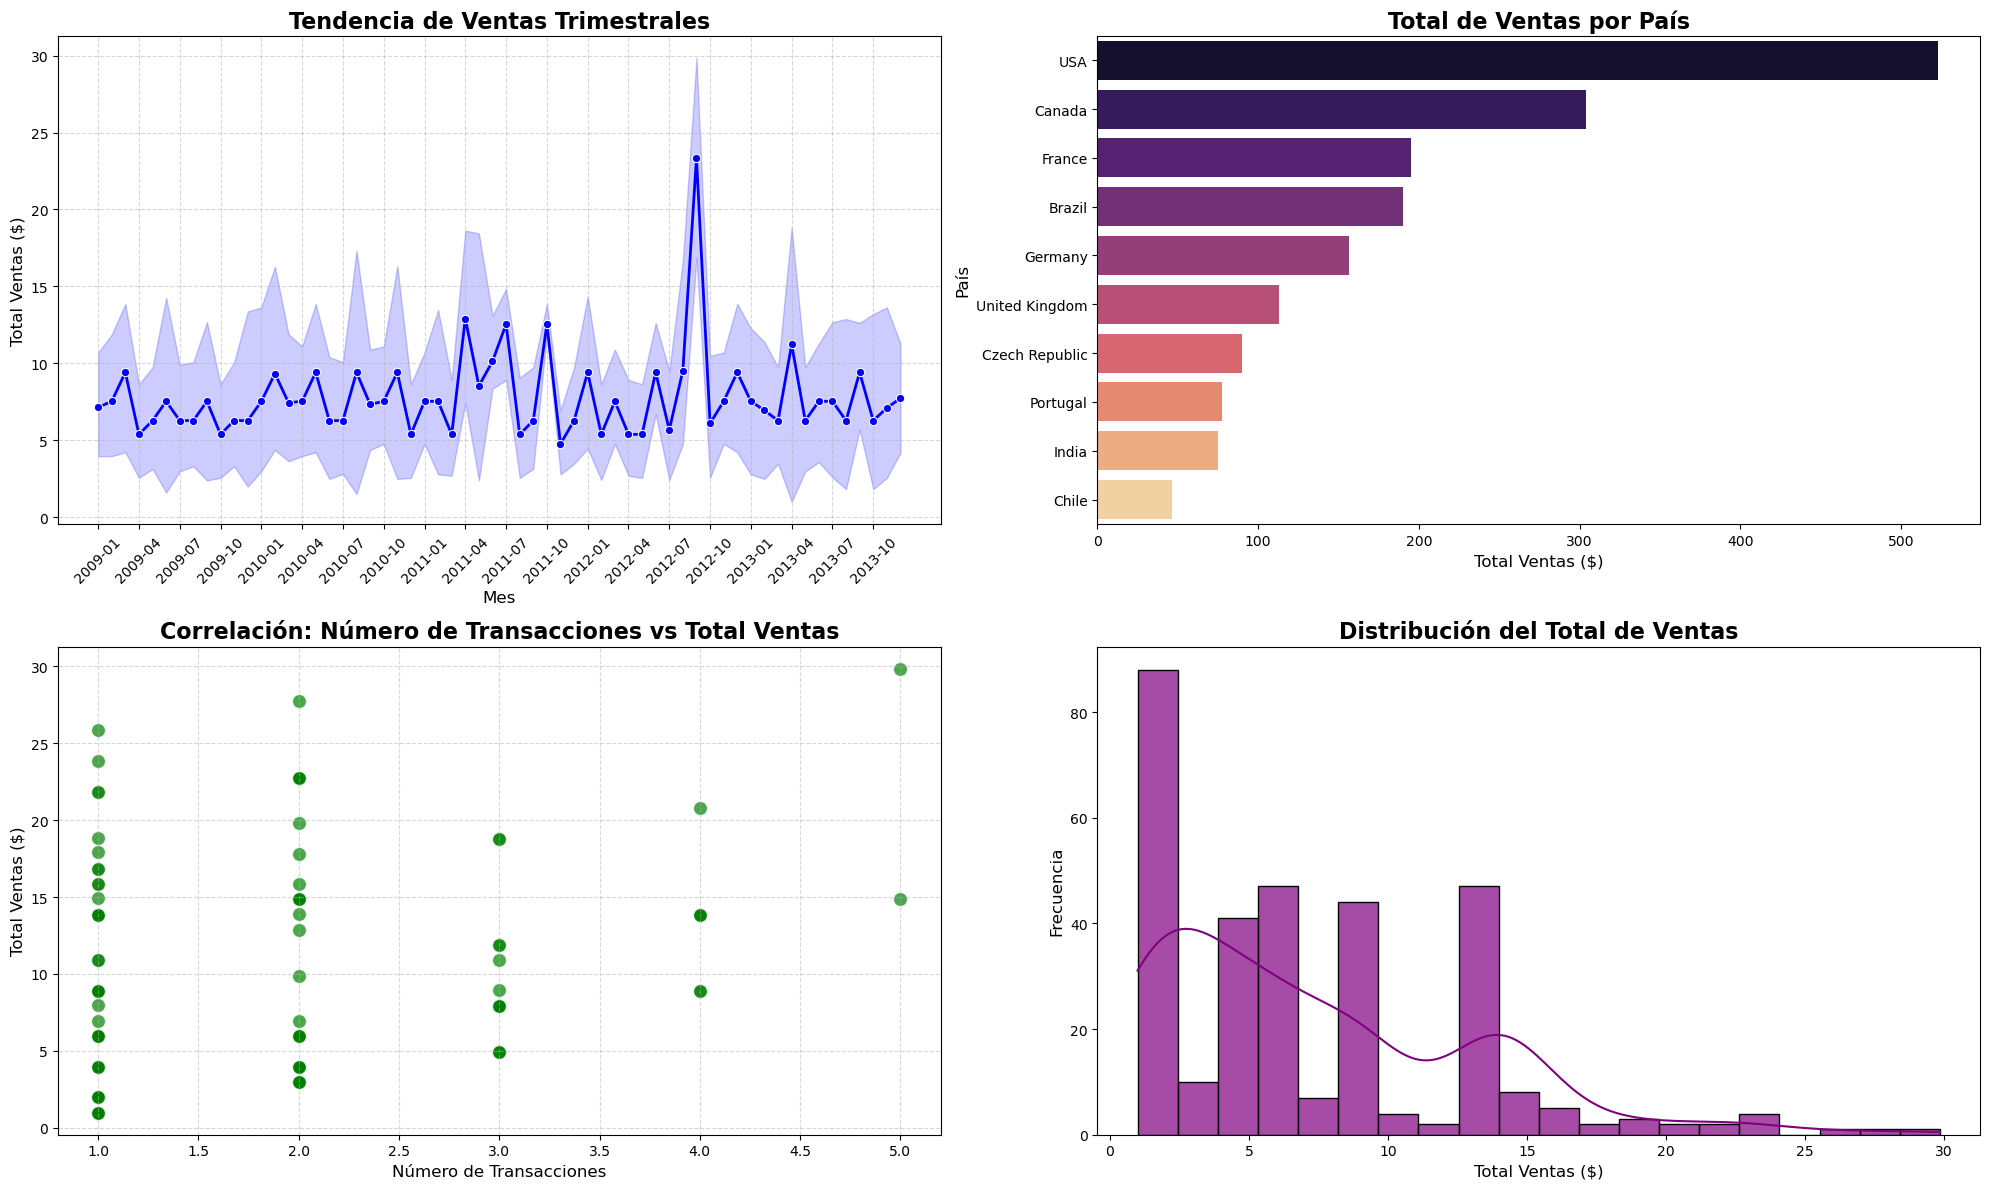


Reporte de ventas del a√±o 2011:

Estad√≠sticas Generales:
Total de ventas: $469.58
Promedio de ventas: $7.70
N√∫mero total de transacciones: 83

Top 5 Pa√≠ses por Ventas Totales:
Pais
USA        103.01
Canada      55.44
Germany     48.57
France      42.61
Ireland     32.75
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


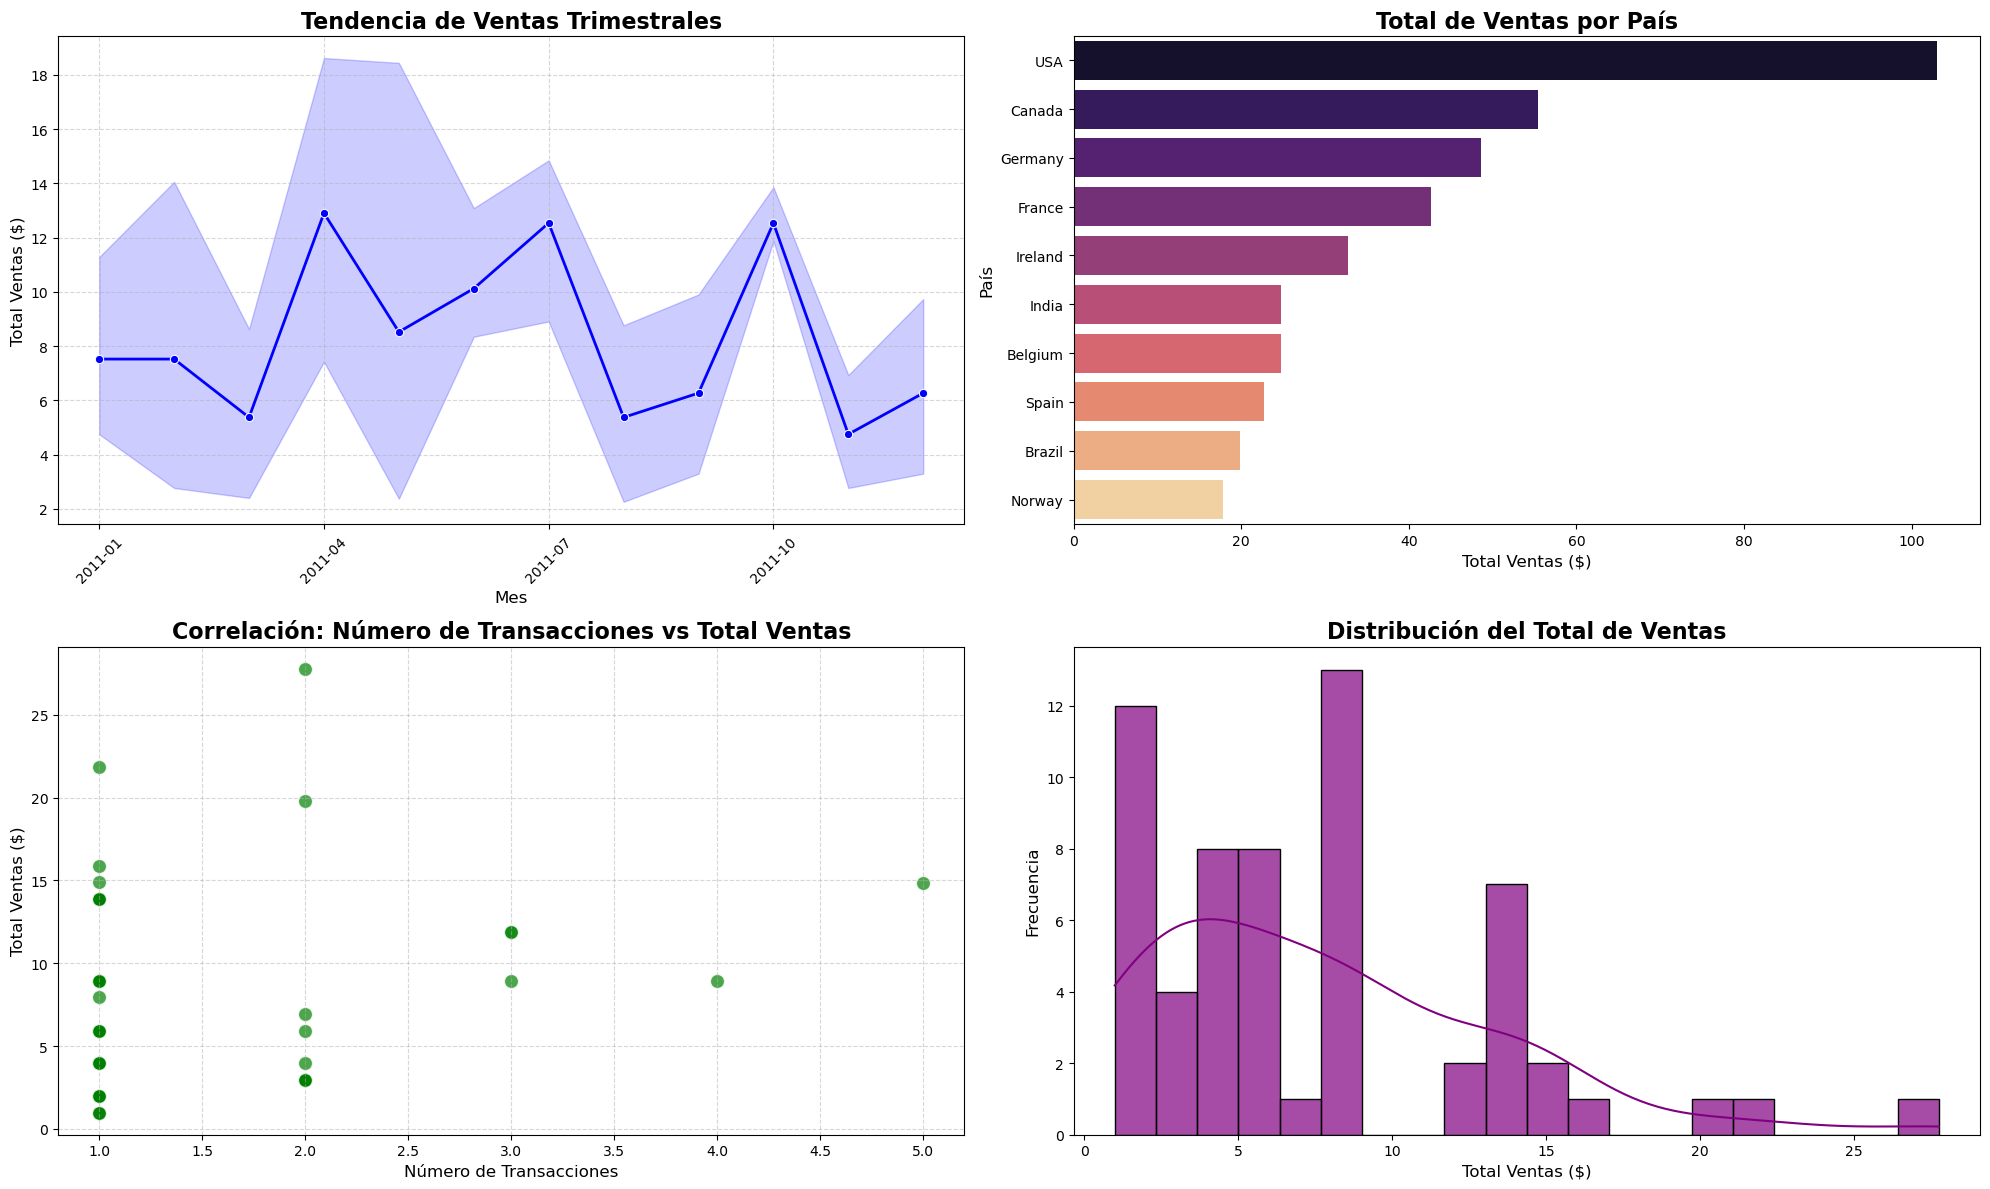


Reporte de ventas para USA con monto m√≠nimo de $10:

Estad√≠sticas Generales:
Total de ventas: $220.03
Promedio de ventas: $14.67
N√∫mero total de transacciones: 15

Top 5 Pa√≠ses por Ventas Totales:
Pais
USA    220.03
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


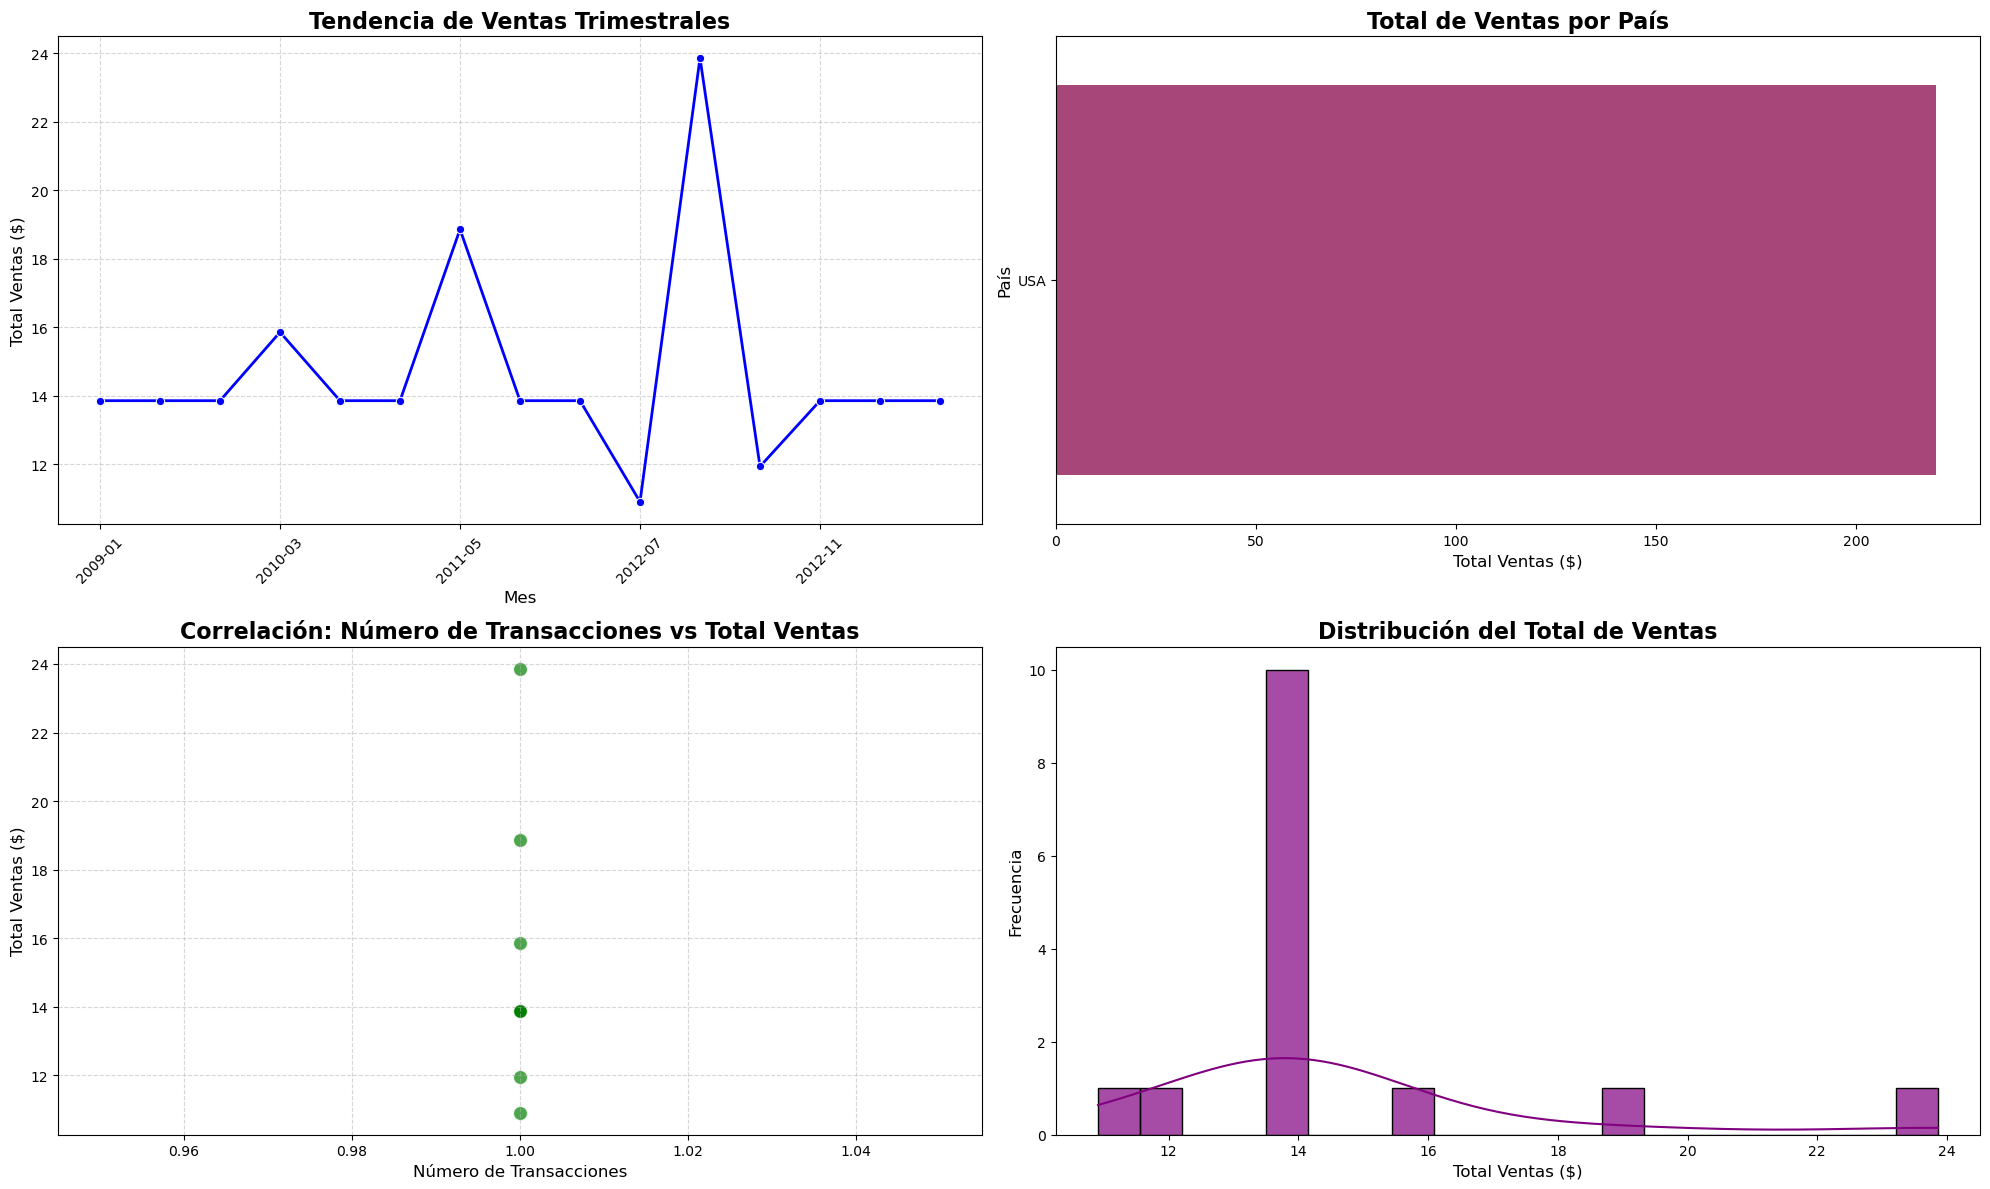


Reporte de ventas del a√±o 2011 para USA con monto m√≠nimo de $10:

Estad√≠sticas Generales:
Total de ventas: $46.58
Promedio de ventas: $15.53
N√∫mero total de transacciones: 3

Top 5 Pa√≠ses por Ventas Totales:
Pais
USA    46.58
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


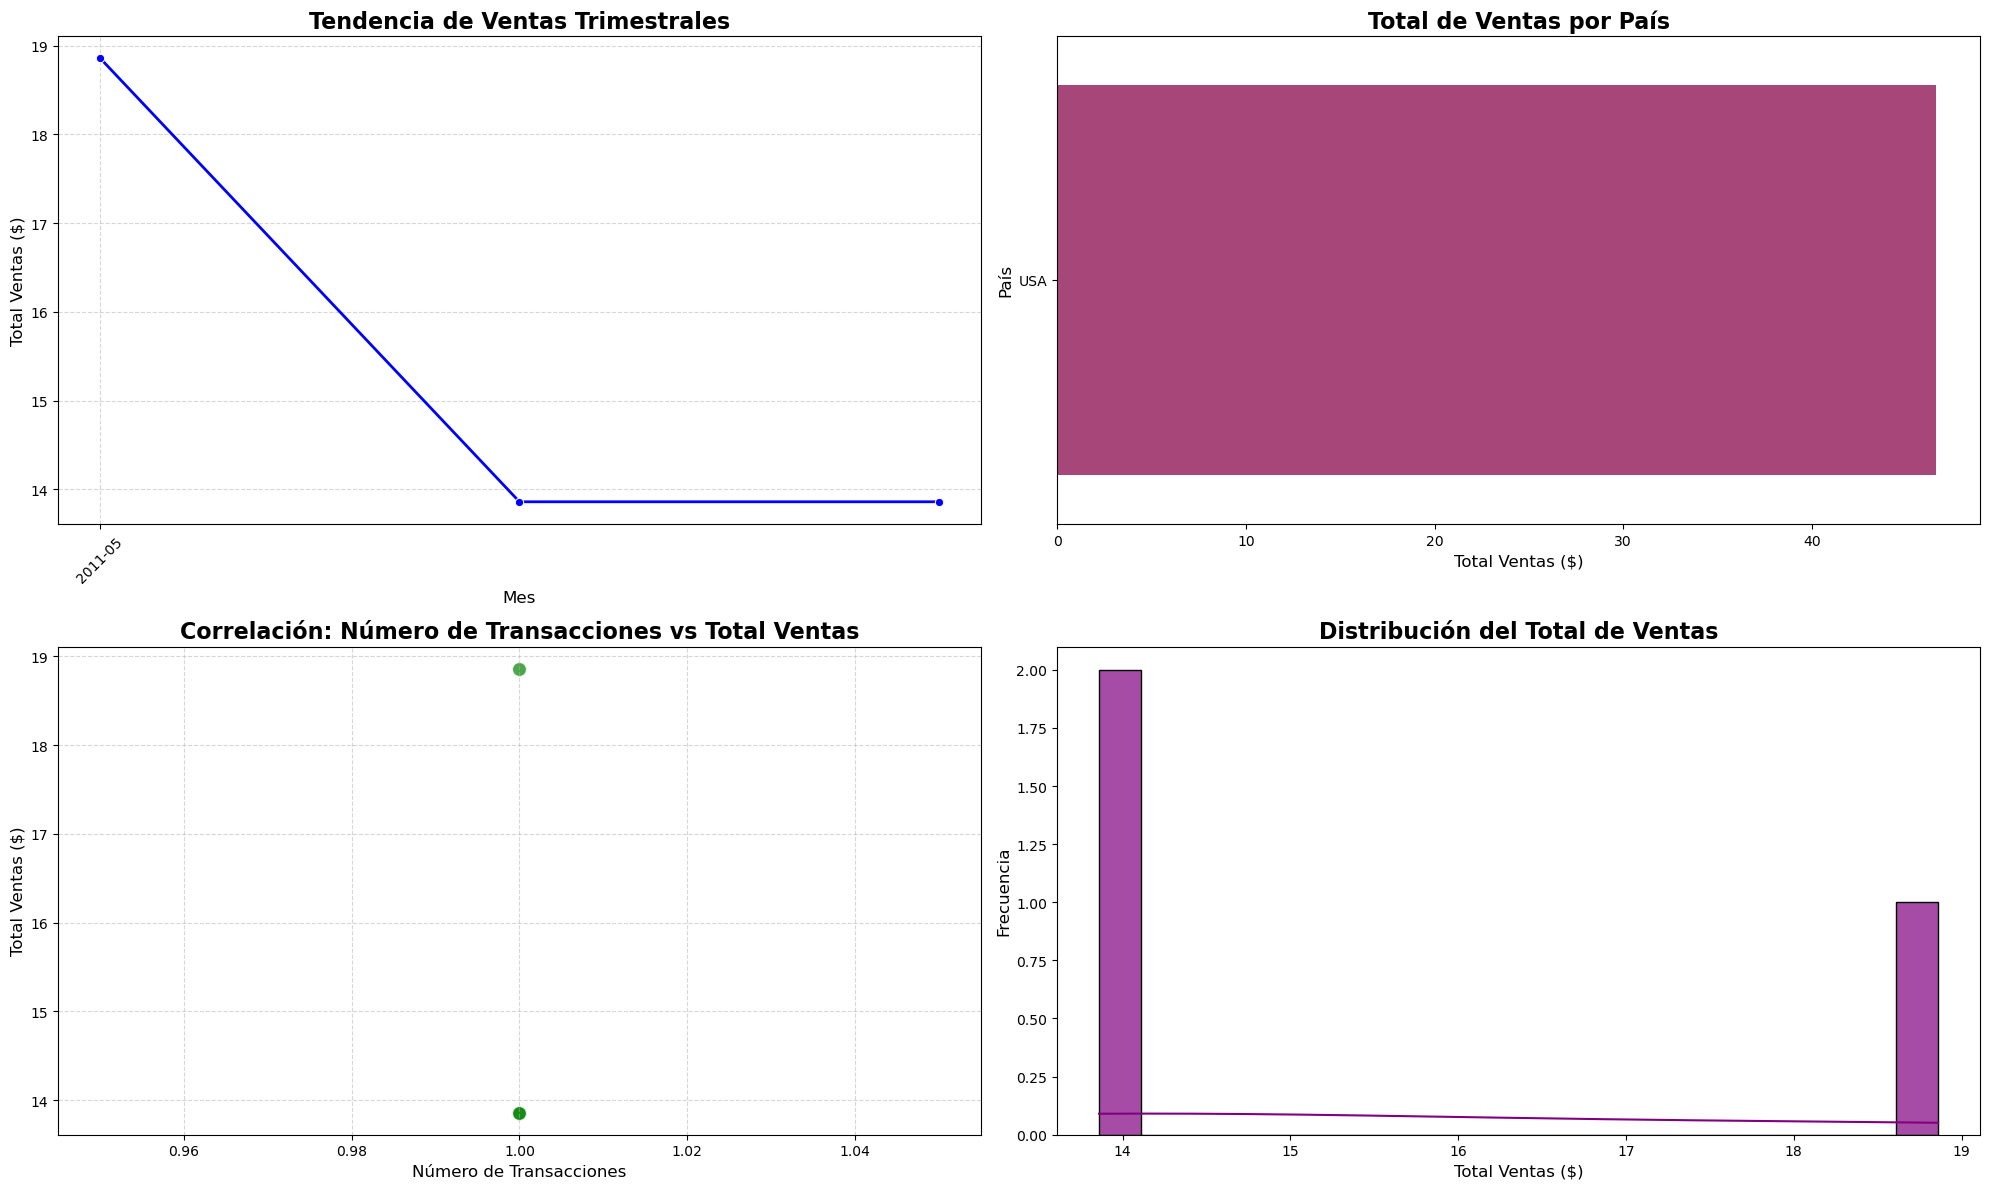

In [9]:
if __name__ == "__main__":
    #1. An√°lisis general de ventas
    print("Reporte general de ventas:")
    df_general = analizar_ventas(engine)
    
    #2. An√°lisis de ventas para el a√±o 2011
    print("\nReporte de ventas del a√±o 2011:")
    df_2011 = analizar_ventas(engine, year="2011")
    
    #3. An√°lisis de ventas para USA con monto m√≠nimo de $10
    print("\nReporte de ventas para USA con monto m√≠nimo de $10:")
    df_usa = analizar_ventas(engine, country="USA", min_total=10)

    #4. An√°lisis de ventas para 2011 en USA con monto m√≠nimo de $10
    print("\nReporte de ventas del a√±o 2011 para USA con monto m√≠nimo de $10:")
    df_2011_usa = analizar_ventas(engine, year="2011", country="USA", min_total=10)

## 2. Query Din√°mica B√∫squeda de Canciones

In [12]:
def buscar_canciones(engine, genre=None, min_duration=None, max_duration=None, artist_name=None):
    """
    Realiza una b√∫squeda din√°mica de canciones en la base de datos Chinook.

    Par√°metros:
        engine: Conexi√≥n a la base de datos.
        genre (str): G√©nero musical para filtrar (opcional).
        min_duration (int): Duraci√≥n m√≠nima en milisegundos (opcional).
        max_duration (int): Duraci√≥n m√°xima en milisegundos (opcional).
        artist_name (str): Nombre del artista para filtrar (opcional).

    Retorna:
        DataFrame con los resultados de la consulta.
    """

    # Construcci√≥n de la query din√°mica
    query = """
    SELECT 
        Track.Name AS Cancion,
        Artist.Name AS Artista,
        Genre.Name AS Genero,
        Track.Milliseconds AS Duracion,
        Track.UnitPrice AS Precio
    FROM Track
    JOIN Album ON Track.AlbumId = Album.AlbumId
    JOIN Artist ON Album.ArtistId = Artist.ArtistId
    JOIN Genre ON Track.GenreId = Genre.GenreId
    WHERE 1=1
    """
    
    params = {}

    if genre:
        query += " AND Genre.Name = :genre"
        params["genre"] = genre
    if min_duration:
        query += " AND Track.Milliseconds >= :min_duration"
        params["min_duration"] = min_duration
    if max_duration:
        query += " AND Track.Milliseconds <= :max_duration"
        params["max_duration"] = max_duration
    if artist_name:
        query += " AND Artist.Name LIKE :artist_name"
        params["artist_name"] = f"%{artist_name}%"

    query += " ORDER BY Track.Milliseconds DESC"  # Ordena por duraci√≥n descendente

    # Ejecutar la consulta
    df = pd.read_sql(query, engine, params=params)

    # Convertir duraci√≥n de milisegundos a minutos y segundos
    df["Duracion_Minutos"] = df["Duracion"] / 60000  # Convertir a minutos
    df["Duracion_Segundos"] = df["Duracion"] / 1000  # Convertir a segundos

    # Calcular estad√≠sticas
    total_canciones = len(df)
    duracion_promedio = df["Duracion_Minutos"].mean()
    precio_promedio = df["Precio"].mean()

    top_artistas = (df["Artista"].value_counts().head(10))  # Top 10 artistas con m√°s canciones

    # Imprimir estad√≠sticas generales
    print("\nüìä Estad√≠sticas de Canciones:")
    print(f"Total de canciones encontradas: {total_canciones}")
    print(f"Duraci√≥n promedio: {duracion_promedio:.2f} minutos")
    print(f"Precio promedio: ${precio_promedio:.2f}")
    print("\nüéµ Top 10 Artistas con m√°s canciones:")
    print(top_artistas)

    # Generar visualizaciones
    generar_visualizaciones_canciones(df)

    return df

In [13]:
def generar_visualizaciones_canciones(df):
    """
    Genera visualizaciones de la b√∫squeda de canciones.

    Par√°metros:
        df: DataFrame con las canciones encontradas.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20, 12))

    # Gr√°fico 1: Distribuci√≥n de duraciones de canciones
    plt.subplot(2, 2, 1)
    sns.histplot(df["Duracion_Minutos"], bins=20, kde=True, color="blue", edgecolor="black", alpha=0.7)
    plt.title("Distribuci√≥n de Duraciones de Canciones", fontsize=16, fontweight='bold')
    plt.xlabel("Duraci√≥n (minutos)", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)

    # Gr√°fico 2: Distribuci√≥n de precios por g√©nero
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
    plt.title("Distribuci√≥n de Precios por G√©nero", fontsize=16, fontweight='bold')
    plt.xlabel("G√©nero", fontsize=12)
    plt.ylabel("Precio ($)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)

    # Gr√°fico 3: Top 10 artistas con m√°s canciones
    plt.subplot(2, 2, 3)
    top_artistas = df["Artista"].value_counts().head(10)
    sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
    plt.title("Top 10 Artistas con M√°s Canciones", fontsize=16, fontweight='bold')
    plt.xlabel("N√∫mero de Canciones", fontsize=12)
    plt.ylabel("Artista", fontsize=12)

    # Gr√°fico 4: Duraci√≥n promedio por g√©nero
    plt.subplot(2, 2, 4)
    mean_duration = df.groupby("Genero")["Duracion_Minutos"].mean().sort_values(ascending=False)
    sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")
    plt.title("Duraci√≥n Promedio por G√©nero", fontsize=16, fontweight='bold')
    plt.xlabel("Duraci√≥n Promedio (min)", fontsize=12)
    plt.ylabel("G√©nero", fontsize=12)

    plt.tight_layout()
    plt.show()


# Explicaci√≥n del C√≥digo - B√∫squeda de Canciones en la Base de Datos Chinook

## 1. Funci√≥n `buscar_canciones`

### Objetivo
La funci√≥n `buscar_canciones` permite realizar una consulta din√°mica en la base de datos Chinook para obtener informaci√≥n sobre canciones aplicando distintos filtros.

### Construcci√≥n de la consulta SQL
La consulta selecciona los siguientes campos:
- `Track.Name` ‚Üí Nombre de la canci√≥n.
- `Artist.Name` ‚Üí Nombre del artista.
- `Genre.Name` ‚Üí G√©nero musical.
- `Track.Milliseconds` ‚Üí Duraci√≥n de la canci√≥n en milisegundos.
- `Track.UnitPrice` ‚Üí Precio de la canci√≥n.

Para acceder a estos datos, se realizan uniones (`JOIN`) con las siguientes tablas:
- `Album` para obtener el ID del √°lbum.
- `Artist` para obtener el nombre del artista.
- `Genre` para obtener el g√©nero musical.

La consulta utiliza `WHERE 1=1` como condici√≥n base, lo que facilita la adici√≥n de filtros din√°micos sin modificar la estructura principal de la consulta.

---

## 2. Incorporaci√≥n de Filtros Din√°micos

La funci√≥n permite aplicar filtros opcionales para personalizar la b√∫squeda de canciones. Estos filtros son:

| Filtro        | Descripci√≥n |
|--------------|------------|
| `genre` | Filtra canciones por g√©nero musical. |
| `min_duration` | Excluye canciones con duraci√≥n menor al valor especificado (en milisegundos). |
| `max_duration` | Excluye canciones con duraci√≥n mayor al valor especificado (en milisegundos). |
| `artist_name` | Filtra canciones de un artista espec√≠fico. |

Cada filtro es opcional y se agrega a la consulta solo si el usuario lo especifica. Esto permite que la funci√≥n sea flexible y adaptable a diferentes necesidades de an√°lisis.

---

## 3. Ejecuci√≥n de la Consulta y Transformaci√≥n de Datos

- La consulta se ejecuta usando `pd.read_sql`, lo que permite obtener los resultados en un **DataFrame de Pandas**.
- Los valores de duraci√≥n en **milisegundos** se convierten en:
  - **Minutos** (`Duracion_Minutos`).
  - **Segundos** (`Duracion_Segundos`).

Esta transformaci√≥n facilita la interpretaci√≥n de los datos.

---

## 4. C√°lculo de Estad√≠sticas

Despu√©s de obtener los datos, se calculan indicadores clave para proporcionar un resumen de la informaci√≥n obtenida:

### Estad√≠sticas Generales
- N√∫mero total de canciones encontradas.
- Duraci√≥n promedio de las canciones (en minutos).
- Precio promedio de las canciones.
- Top 10 artistas con m√°s canciones en la base de datos.

Estos datos permiten obtener una visi√≥n general de las caracter√≠sticas de las canciones seleccionadas.

---

## 5. Generaci√≥n de Visualizaciones

Se generan cuatro gr√°ficos principales para analizar la informaci√≥n obtenida:

1. **Distribuci√≥n de duraciones de canciones**  
   - Se utiliza un histograma para visualizar la cantidad de canciones seg√∫n su duraci√≥n.

2. **Distribuci√≥n de precios por g√©nero**  
   - Se usa un diagrama de caja para observar c√≥mo var√≠an los precios en diferentes g√©neros musicales.

3. **Top 10 artistas con m√°s canciones**  
   - Se representa en un gr√°fico de barras los artistas con mayor cantidad de canciones en la base de datos.

4. **Duraci√≥n promedio por g√©nero**  
   - Se muestra la duraci√≥n promedio de las canciones agrupadas por g√©nero.

Estos gr√°ficos ayudan a identificar patrones y tendencias en la base de datos.

---

## 6. Ejecuci√≥n del C√≥digo en `if __name__ == "__main__"`

El c√≥digo se ejecuta en cuatro escenarios distintos para analizar diferentes aspectos de la base de datos:

1. **B√∫squeda de canciones de Rock**  
2. **B√∫squeda de canciones largas (m√°s de 5 minutos)**  
3. **B√∫squeda de canciones de Queen**  
4. **B√∫squeda de canciones de Rock con duraci√≥n entre 3 y 5 minutos**  

Cada b√∫squeda genera:
- Estad√≠sticas en consola.
- Visualizaciones para facilitar la exploraci√≥n de los datos.

---

## Conclusi√≥n

El c√≥digo est√° dise√±ado para realizar una b√∫squeda flexible y personalizada de canciones en la base de datos Chinook. 

Este an√°lisis permite:
- Identificar tendencias en la duraci√≥n y precios de las canciones.
- Descubrir los artistas con mayor presencia en la base de datos.
- Comparar los g√©neros musicales seg√∫n sus caracter√≠sticas.

El c√≥digo es modular y escalable, lo que permite su adaptaci√≥n a nuevos an√°lisis sin necesidad de modificar su estructura principal.



üé∏ Reporte de canciones de Rock:

üìä Estad√≠sticas de Canciones:
Total de canciones encontradas: 1297
Duraci√≥n promedio: 4.73 minutos
Precio promedio: $0.99

üéµ Top 10 Artistas con m√°s canciones:
Artista
Led Zeppelin                    114
U2                              112
Deep Purple                      92
Iron Maiden                      81
Pearl Jam                        54
Van Halen                        52
Queen                            45
The Rolling Stones               41
Creedence Clearwater Revival     40
Kiss                             35
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


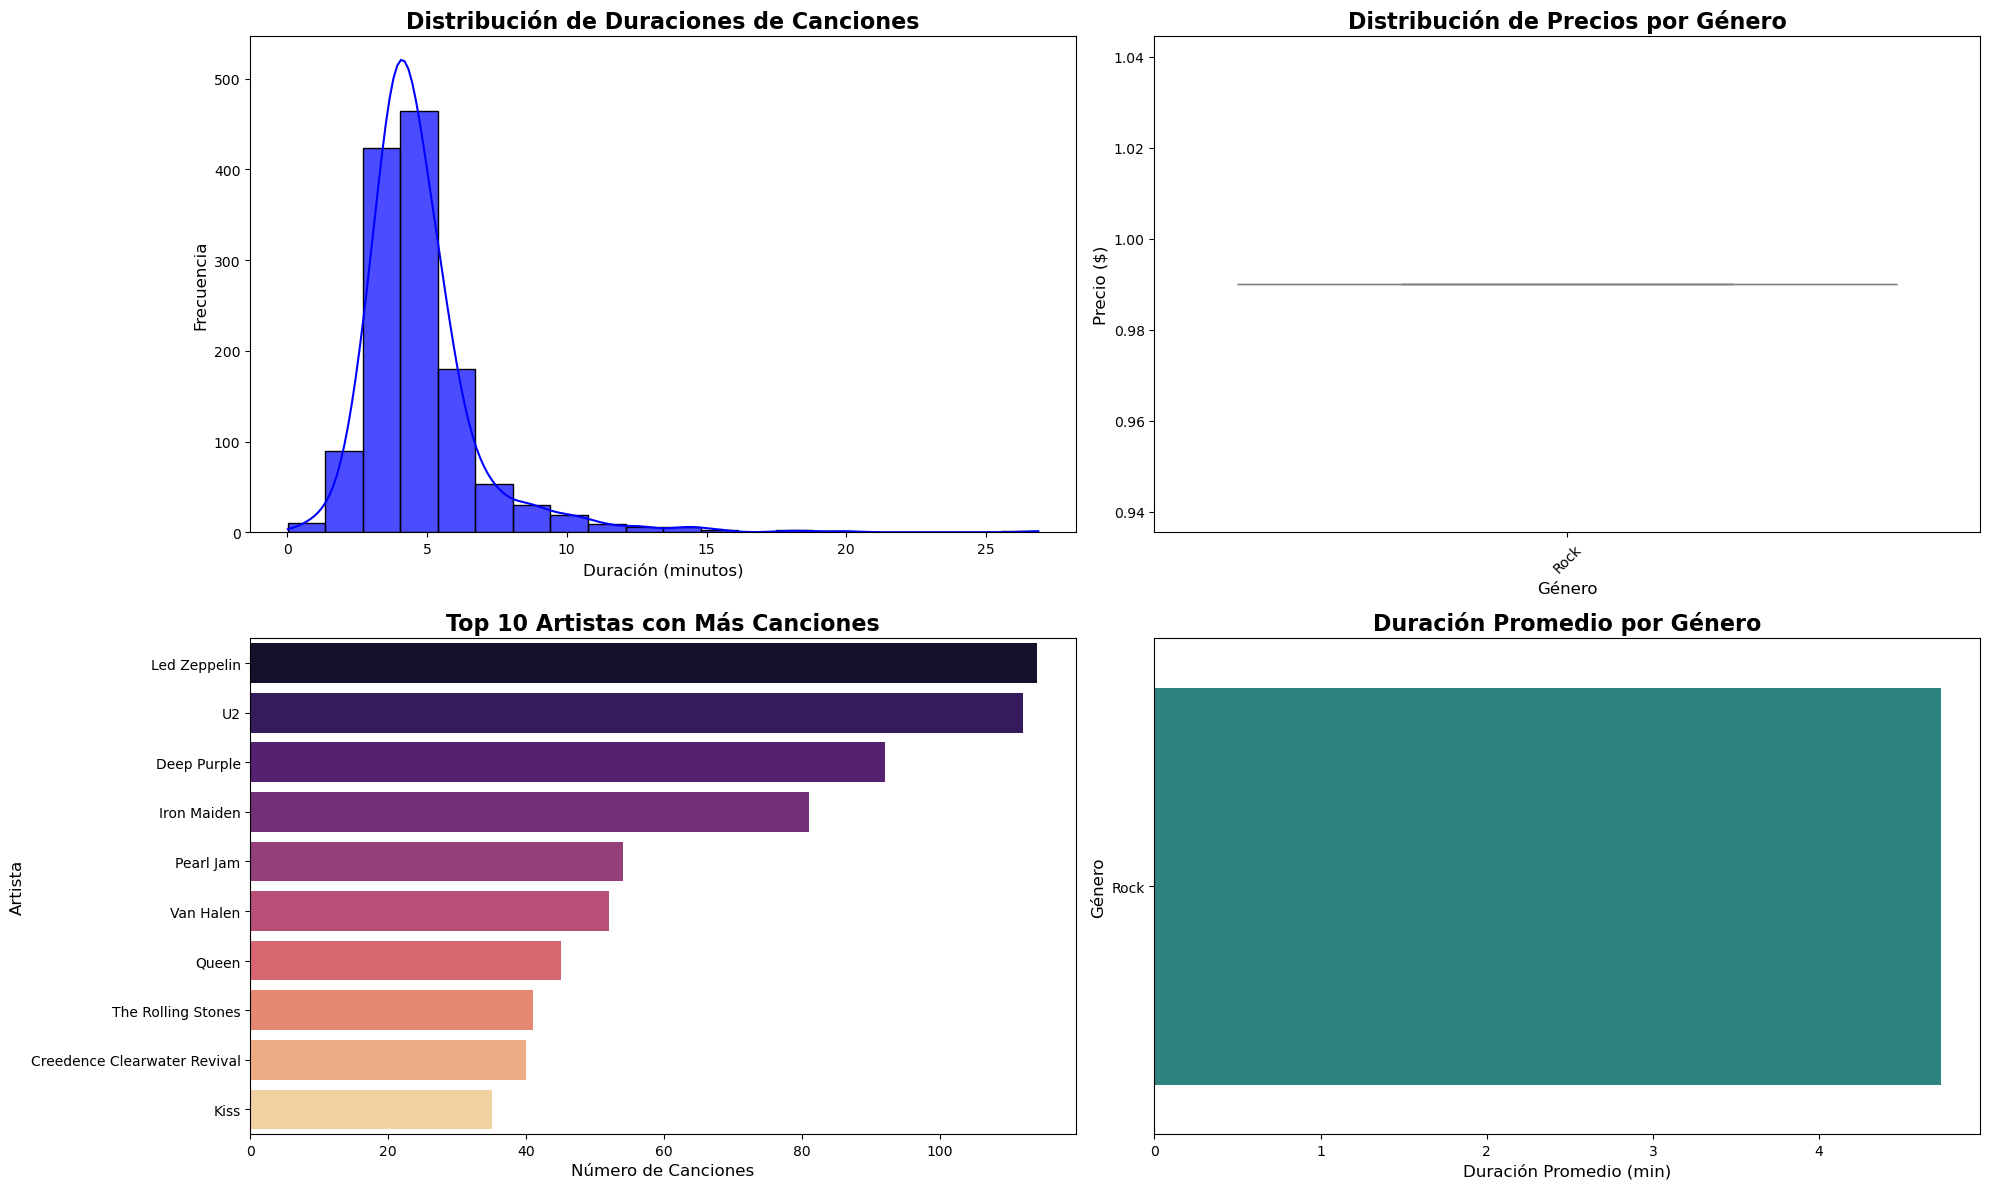


‚è≥ Reporte de canciones largas (>5 min):

üìä Estad√≠sticas de Canciones:
Total de canciones encontradas: 1069
Duraci√≥n promedio: 13.14 minutos
Precio promedio: $1.19

üéµ Top 10 Artistas con m√°s canciones:
Artista
Iron Maiden                       117
Lost                               91
Metallica                          75
Led Zeppelin                       54
The Office                         53
Deep Purple                        46
U2                                 29
Battlestar Galactica (Classic)     24
Heroes                             23
Battlestar Galactica               20
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


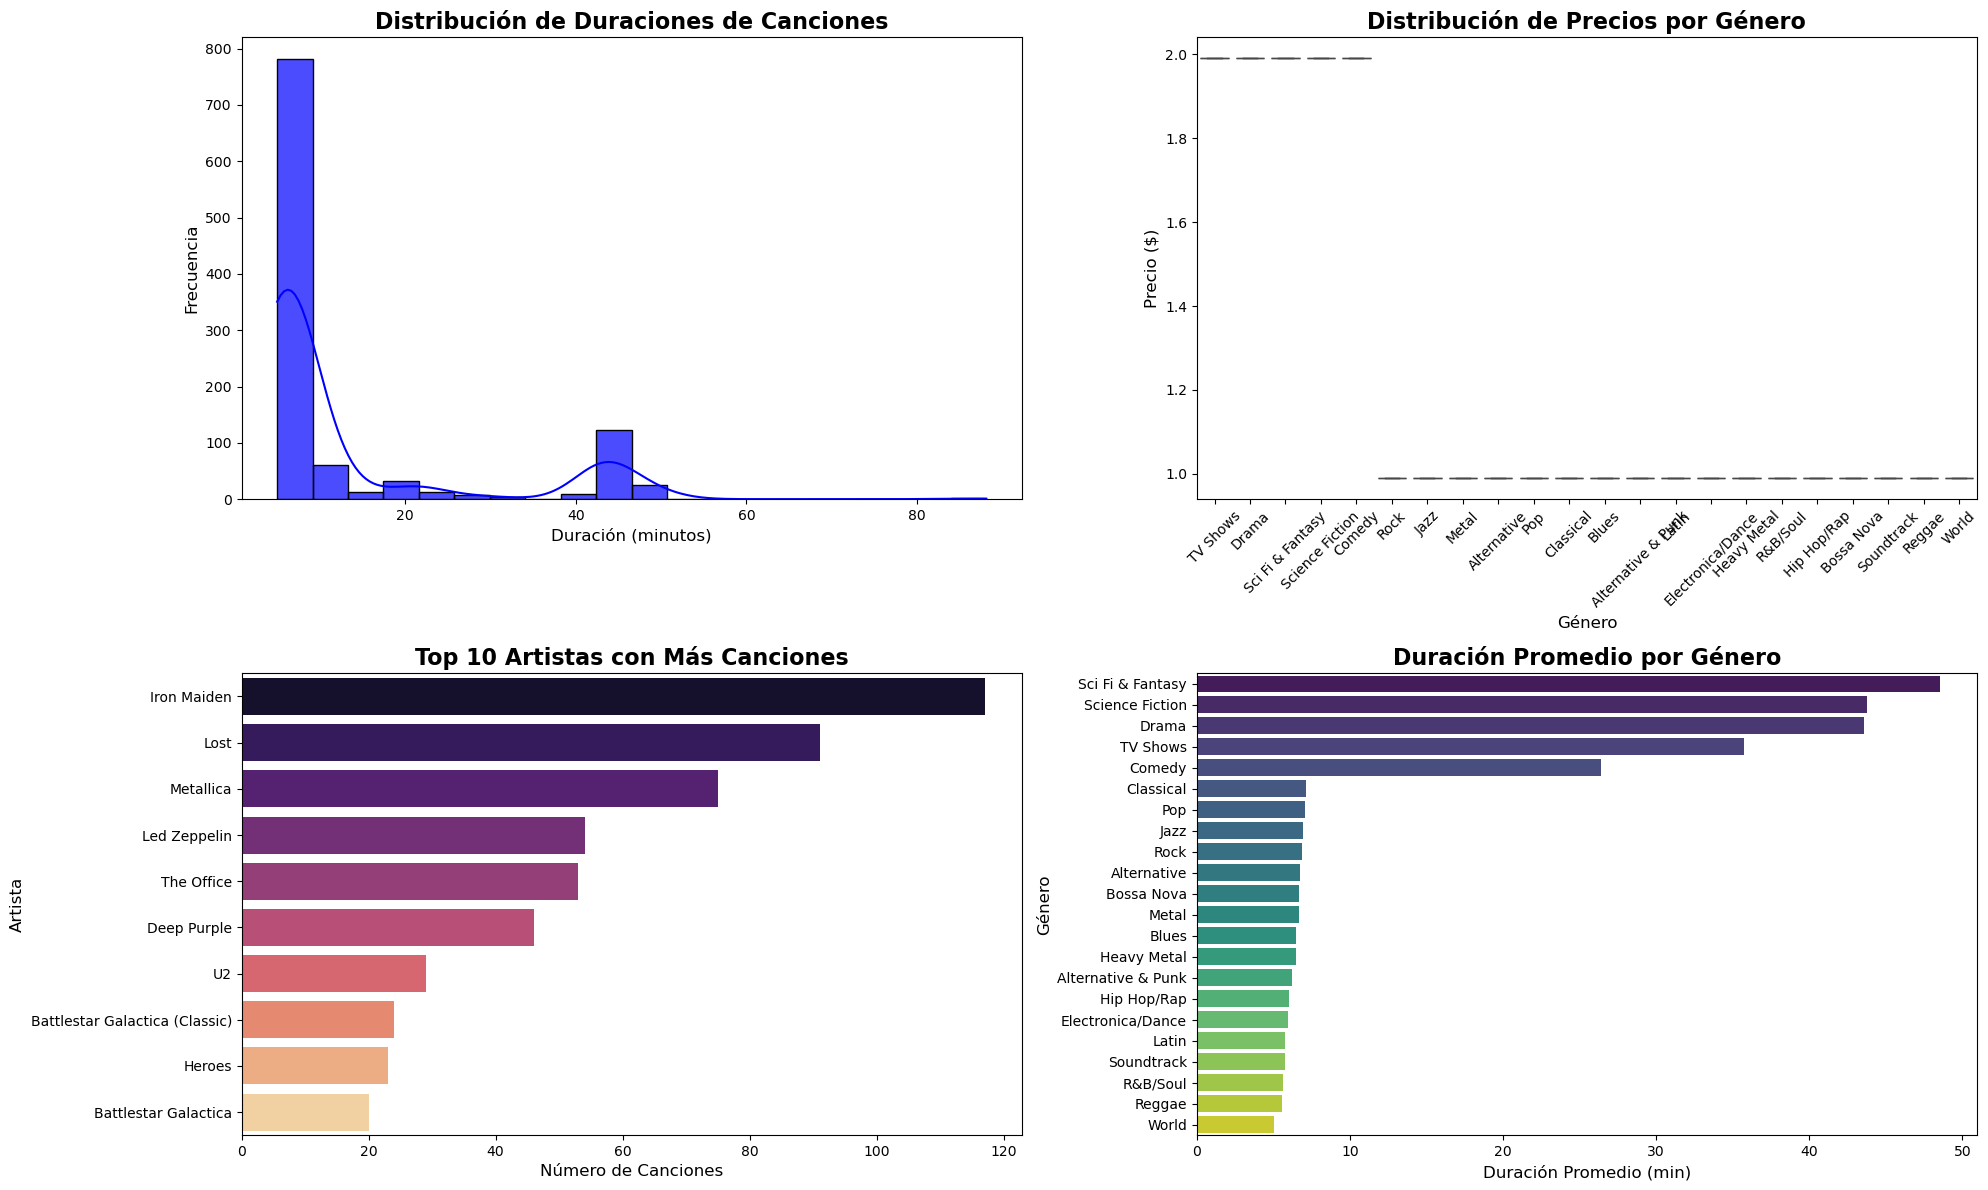


üëë Reporte de canciones de Queen:

üìä Estad√≠sticas de Canciones:
Total de canciones encontradas: 45
Duraci√≥n promedio: 3.86 minutos
Precio promedio: $0.99

üéµ Top 10 Artistas con m√°s canciones:
Artista
Queen    45
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


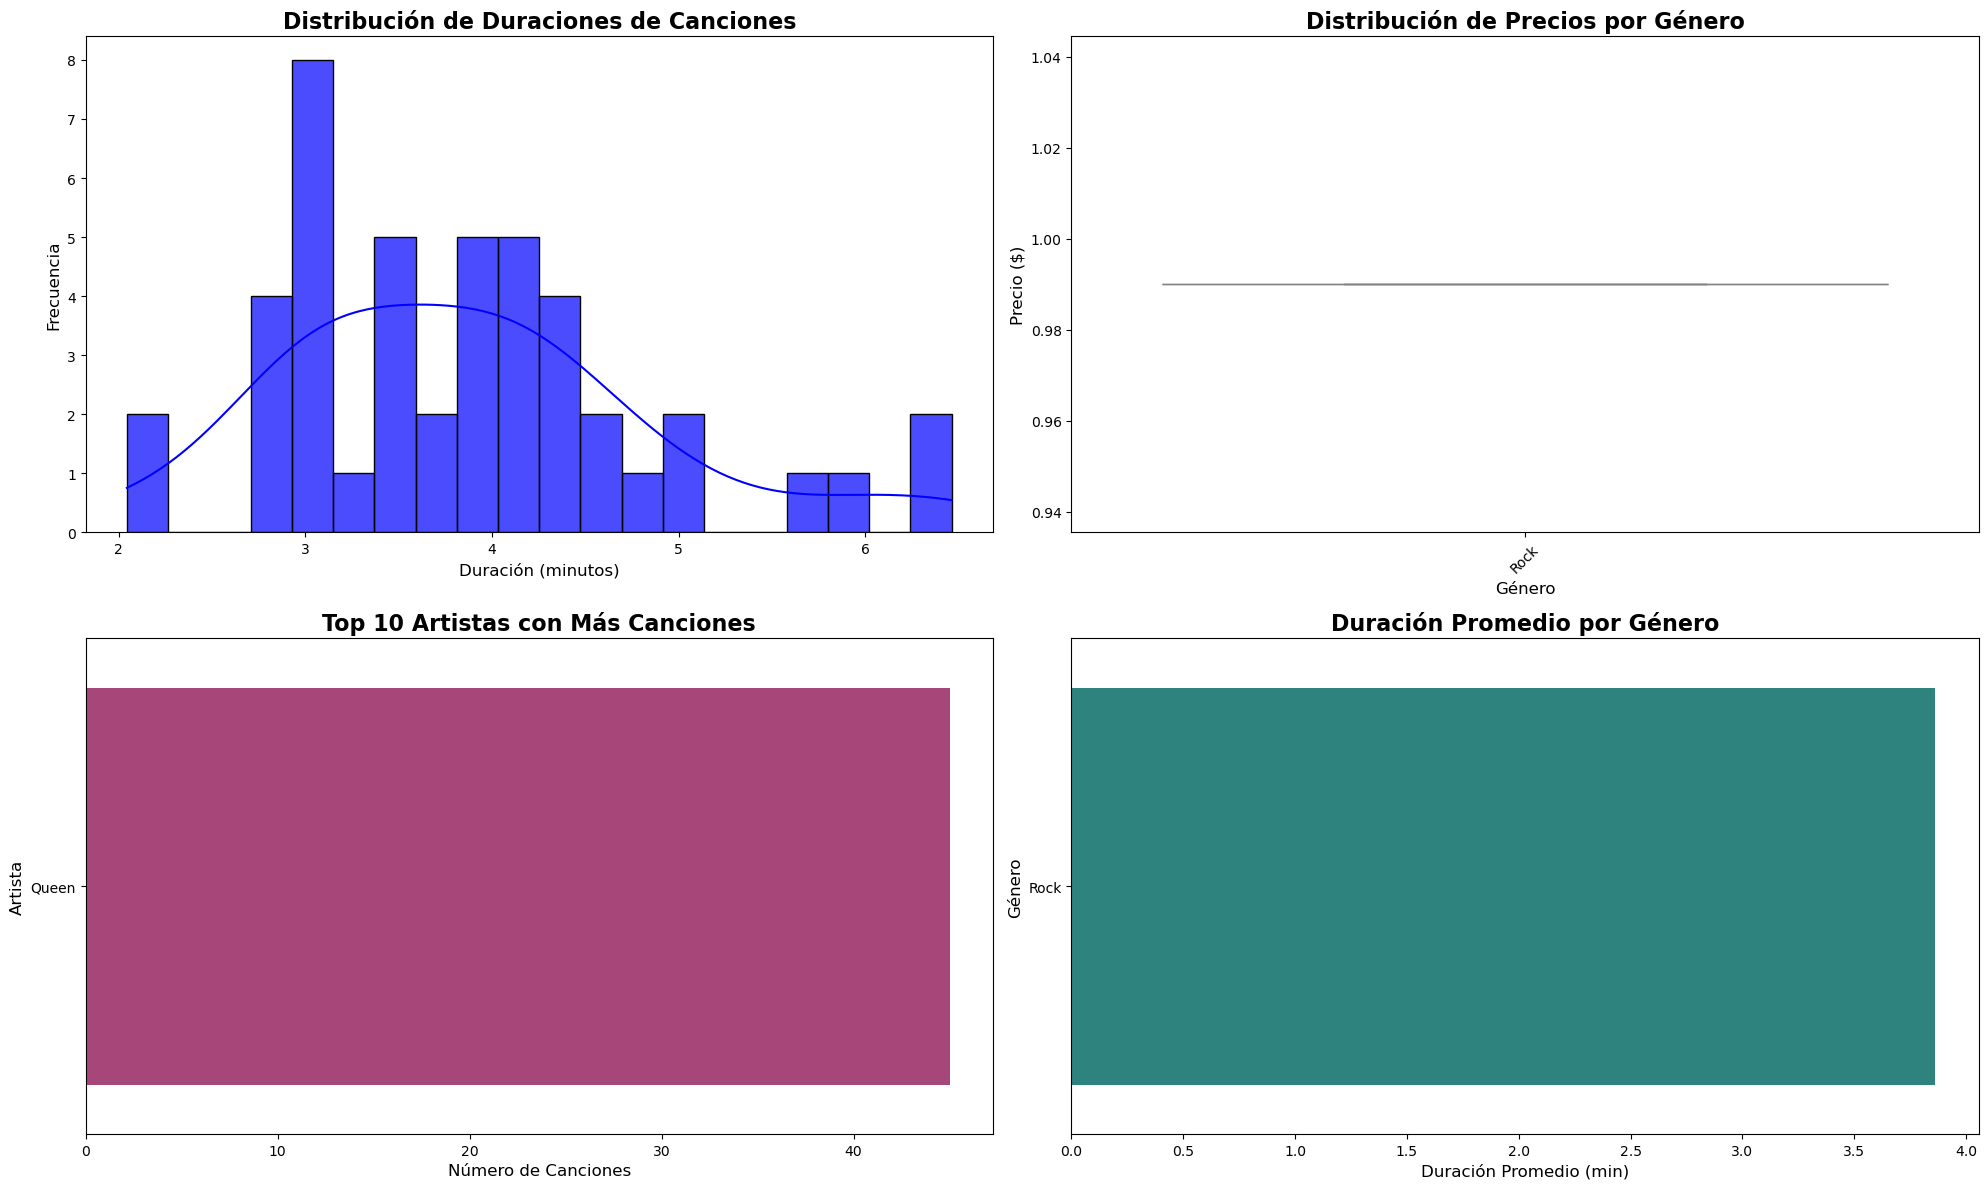


üé∂ Reporte de canciones de Rock entre 3 y 5 minutos:

üìä Estad√≠sticas de Canciones:
Total de canciones encontradas: 737
Duraci√≥n promedio: 4.04 minutos
Precio promedio: $0.99

üéµ Top 10 Artistas con m√°s canciones:
Artista
U2                       76
Led Zeppelin             50
Deep Purple              45
Queen                    34
Pearl Jam                33
Lenny Kravitz            28
Kiss                     25
Van Halen                25
The Cult                 24
Red Hot Chili Peppers    24
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


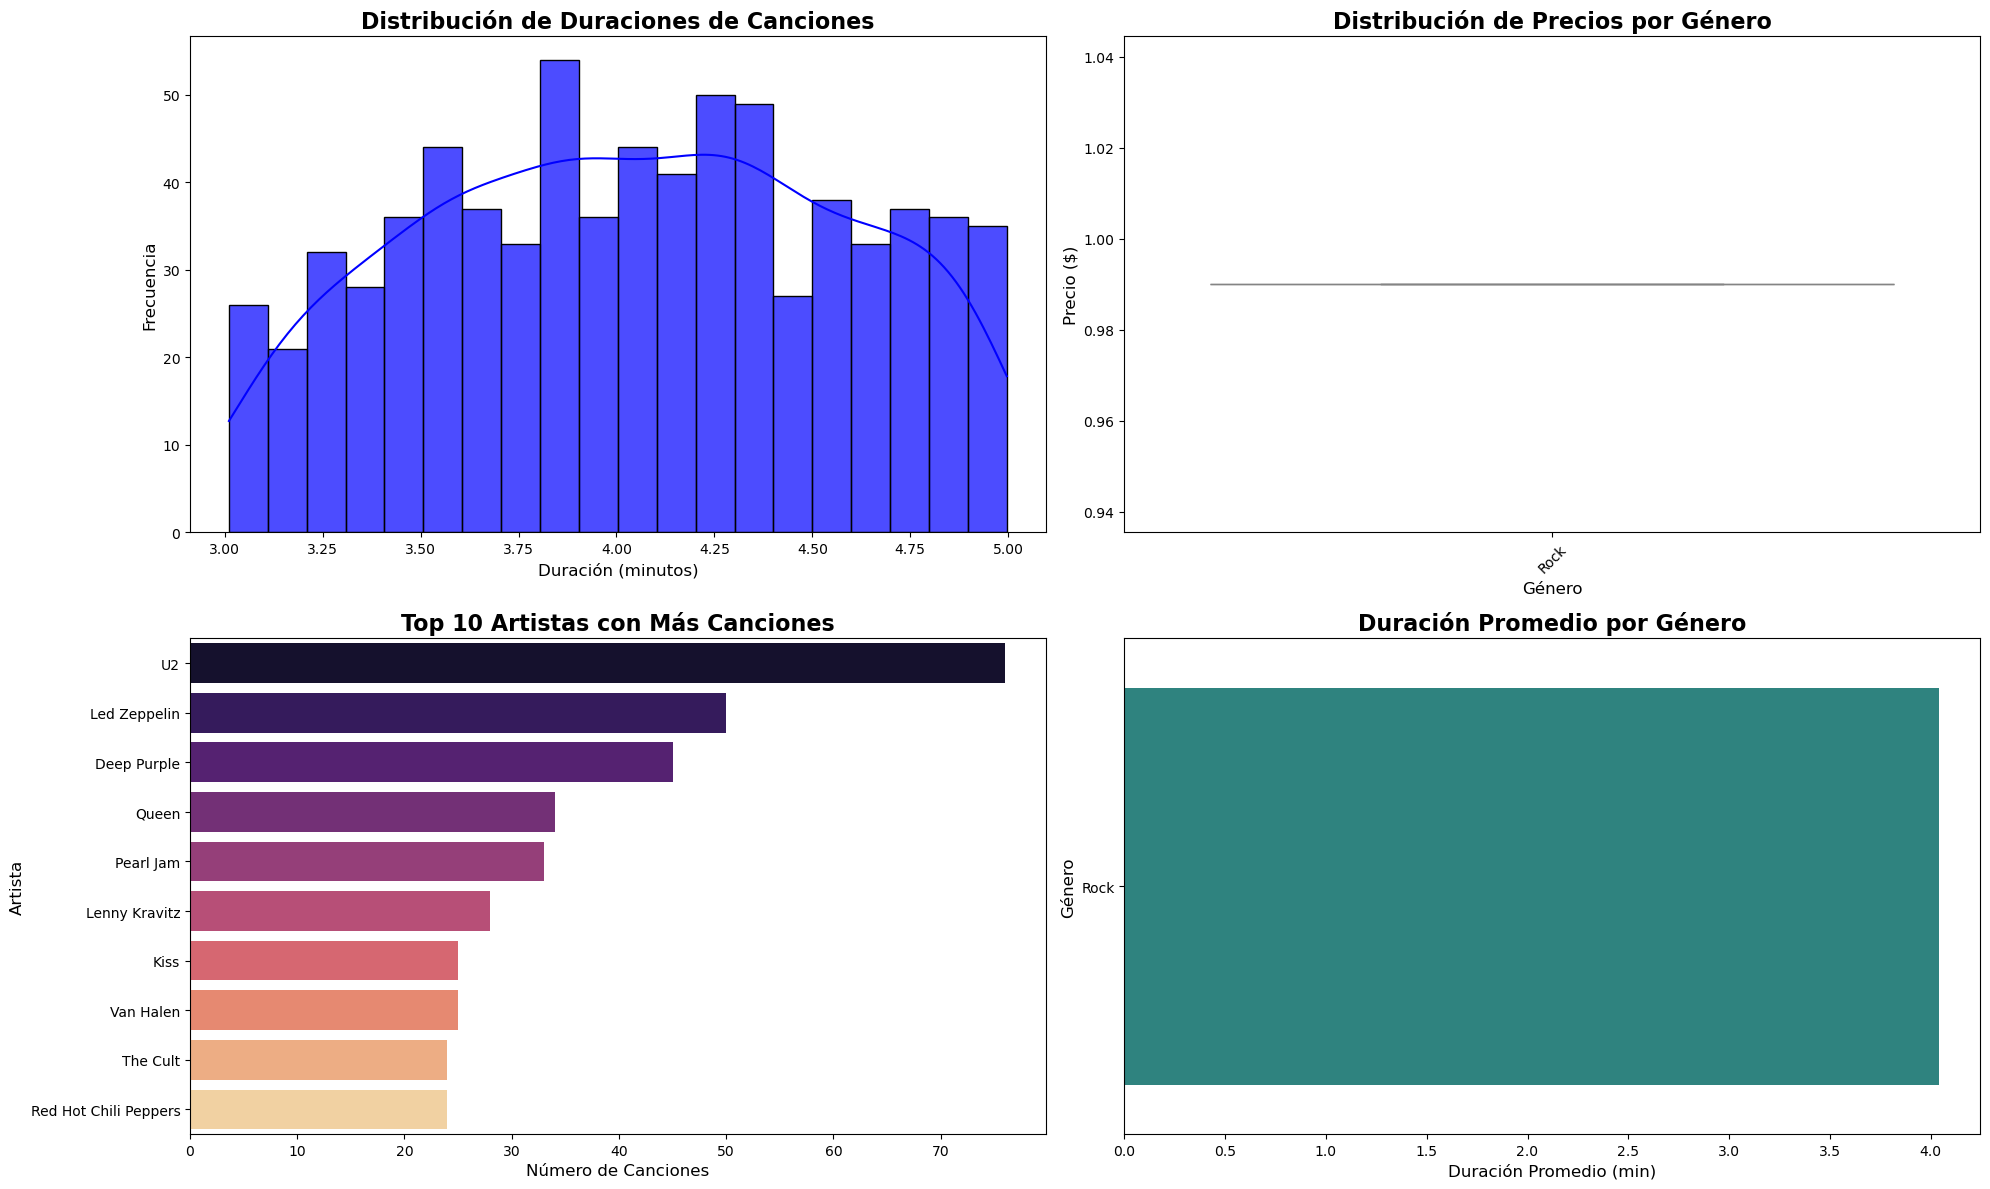

In [14]:
if __name__ == "__main__":
    # 1. B√∫squeda de canciones de Rock
    print("\n Reporte de canciones de Rock:")
    df_rock = buscar_canciones(engine, genre="Rock")

    # 2. B√∫squeda de canciones largas (m√°s de 5 minutos)
    print("\n Reporte de canciones largas (>5 min):")
    df_largas = buscar_canciones(engine, min_duration=300000)

    # 3. B√∫squeda de canciones de Queen
    print("\n Reporte de canciones de Queen:")
    df_queen = buscar_canciones(engine, artist_name="Queen")

    # 4. Reporte de canciones de Rock entre 3 y 5 minutos
    print("\n Reporte de canciones de Rock entre 3 y 5 minutos:")
    df_rock_3_5min = buscar_canciones(engine, genre="Rock", min_duration=180000, max_duration=300000)


## 3. Query Din√°mica An√°lisis de G√©neros Musicales

In [15]:
def analizar_generos(engine, min_tracks=None):
    """
    Realiza un an√°lisis de g√©neros musicales en la base de datos Chinook.

    Par√°metros:
        engine: Conexi√≥n a la base de datos.
        min_tracks (int): N√∫mero m√≠nimo de canciones para filtrar g√©neros (opcional).

    Retorna:
        DataFrame con los resultados de la consulta.
    """

    # Construcci√≥n de la query din√°mica
    query = """
    SELECT 
        Genre.Name AS Genero,
        COUNT(Track.TrackId) AS Num_Tracks,
        AVG(Track.Milliseconds) / 60000 AS Duracion_Promedio_Minutos,
        AVG(Track.UnitPrice) AS Precio_Promedio
    FROM Track
    JOIN Genre ON Track.GenreId = Genre.GenreId
    GROUP BY Genre.Name
    HAVING 1=1
    """
    
    params = {}

    if min_tracks:
        query += " AND COUNT(Track.TrackId) >= :min_tracks"
        params["min_tracks"] = min_tracks

    query += " ORDER BY Num_Tracks DESC"

    # Ejecutar la consulta
    df = pd.read_sql(query, engine, params=params)

    # Calcular estad√≠sticas generales
    total_generos = len(df)
    total_tracks = df["Num_Tracks"].sum()
    duracion_promedio = df["Duracion_Promedio_Minutos"].mean()
    precio_promedio = df["Precio_Promedio"].mean()

    # Identificar g√©neros destacados
    genero_mas_tracks = df.loc[df["Num_Tracks"].idxmax(), "Genero"]
    genero_mayor_duracion = df.loc[df["Duracion_Promedio_Minutos"].idxmax(), "Genero"]
    genero_mayor_precio = df.loc[df["Precio_Promedio"].idxmax(), "Genero"]

    # Imprimir estad√≠sticas generales
    print("\nüìä Estad√≠sticas de G√©neros Musicales:")
    print(f"Total de g√©neros: {total_generos}")
    print(f"Total de canciones: {total_tracks}")
    print(f"Duraci√≥n promedio general: {duracion_promedio:.2f} minutos")
    print(f"Precio promedio general: ${precio_promedio:.2f}")
    print("\nüèÜ G√©neros Destacados:")
    print(f"G√©nero con m√°s tracks: {genero_mas_tracks}")
    print(f"G√©nero con mayor duraci√≥n promedio: {genero_mayor_duracion}")
    print(f"G√©nero con precio promedio m√°s alto: {genero_mayor_precio}")

    # Generar visualizaciones
    generar_visualizaciones_generos(df)

    return df

In [16]:
def generar_visualizaciones_generos(df):
    """
    Genera visualizaciones para el an√°lisis de g√©neros musicales.

    Par√°metros:
        df: DataFrame con el an√°lisis de g√©neros musicales.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20, 12))

    # Gr√°fico 1: N√∫mero de canciones por g√©nero
    plt.subplot(2, 2, 1)
    top_tracks = df.sort_values("Num_Tracks", ascending=False).head(10)
    sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
    plt.title("N√∫mero de Canciones por G√©nero", fontsize=16, fontweight='bold')
    plt.xlabel("N√∫mero de Canciones", fontsize=12)
    plt.ylabel("G√©nero", fontsize=12)

    # Gr√°fico 2: Duraci√≥n promedio por g√©nero
    plt.subplot(2, 2, 2)
    top_duration = df.sort_values("Duracion_Promedio_Minutos", ascending=False).head(10)
    sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
    plt.title("Duraci√≥n Promedio por G√©nero", fontsize=16, fontweight='bold')
    plt.xlabel("Duraci√≥n Promedio (min)", fontsize=12)
    plt.ylabel("G√©nero", fontsize=12)

    # Gr√°fico 3: Precio promedio por g√©nero
    plt.subplot(2, 2, 3)
    top_price = df.sort_values("Precio_Promedio", ascending=False).head(10)
    sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")
    plt.title("Precio Promedio por G√©nero", fontsize=16, fontweight='bold')
    plt.xlabel("Precio Promedio ($)", fontsize=12)
    plt.ylabel("G√©nero", fontsize=12)

    # Gr√°fico 4: Relaci√≥n entre precio promedio y n√∫mero de tracks
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x="Num_Tracks", y="Precio_Promedio", alpha=0.7, color="green", s=100)
    plt.title("Relaci√≥n entre N√∫mero de Canciones y Precio Promedio", fontsize=16, fontweight='bold')
    plt.xlabel("N√∫mero de Canciones", fontsize=12)
    plt.ylabel("Precio Promedio ($)", fontsize=12)

    plt.tight_layout()
    plt.show()

# Explicaci√≥n del C√≥digo - An√°lisis de G√©neros Musicales en la Base de Datos Chinook

## 1. Funci√≥n `analizar_generos`

### Objetivo
La funci√≥n `analizar_generos` permite realizar un an√°lisis de los g√©neros musicales almacenados en la base de datos **Chinook**, obteniendo m√©tricas clave y generando visualizaciones.

### Construcci√≥n de la consulta SQL
La consulta selecciona los siguientes campos:
- `Genre.Name` ‚Üí Nombre del g√©nero musical.
- `COUNT(Track.TrackId)` ‚Üí N√∫mero total de canciones por g√©nero.
- `AVG(Track.Milliseconds) / 60000` ‚Üí Duraci√≥n promedio de las canciones por g√©nero (convertida a minutos).
- `AVG(Track.UnitPrice)` ‚Üí Precio promedio de las canciones en cada g√©nero.

Para extraer esta informaci√≥n, se realiza una uni√≥n (`JOIN`) entre las tablas:
- `Track` para obtener los detalles de las canciones.
- `Genre` para obtener el g√©nero de cada canci√≥n.

Los datos se agrupan por `Genre.Name` para calcular los valores agregados.

---

## 2. Incorporaci√≥n de Filtros Din√°micos

La funci√≥n permite filtrar los g√©neros seg√∫n un umbral m√≠nimo de canciones (`min_tracks`).

| Filtro        | Descripci√≥n |
|--------------|------------|
| `min_tracks` | Excluye g√©neros que tengan menos canciones que el valor especificado. |

Si el usuario define un valor para `min_tracks`, el filtro se aplica en la consulta SQL para restringir los resultados.

---

## 3. Ejecuci√≥n de la Consulta y Transformaci√≥n de Datos

- Se ejecuta la consulta usando `pd.read_sql`, obteniendo un **DataFrame de Pandas** con los resultados.
- La duraci√≥n promedio de las canciones se convierte de **milisegundos a minutos**, facilitando su interpretaci√≥n.

---

## 4. C√°lculo de Estad√≠sticas

Despu√©s de obtener los datos, se calculan m√©tricas clave para analizar la distribuci√≥n de g√©neros musicales:

### Estad√≠sticas Generales
- **N√∫mero total de g√©neros musicales** en la base de datos.
- **N√∫mero total de canciones** en todos los g√©neros.
- **Duraci√≥n promedio general** de las canciones.
- **Precio promedio general** de las canciones.

### G√©neros Destacados
Se identifican los g√©neros con valores extremos en diferentes categor√≠as:
- **G√©nero con m√°s canciones**.
- **G√©nero con la mayor duraci√≥n promedio**.
- **G√©nero con el precio promedio m√°s alto**.

Estos datos ayudan a comprender c√≥mo var√≠an las caracter√≠sticas musicales en la base de datos.

---

## 5. Generaci√≥n de Visualizaciones

Se generan cuatro gr√°ficos para analizar los resultados obtenidos:

1. **N√∫mero de canciones por g√©nero**  
   - Se usa un gr√°fico de barras para mostrar los g√©neros con m√°s canciones.

2. **Duraci√≥n promedio por g√©nero**  
   - Permite comparar la duraci√≥n promedio de las canciones entre diferentes g√©neros.

3. **Precio promedio por g√©nero**  
   - Representa los g√©neros con canciones m√°s caras en promedio.

4. **Relaci√≥n entre n√∫mero de canciones y precio promedio**  
   - Se utiliza un gr√°fico de dispersi√≥n para visualizar si existe una relaci√≥n entre el n√∫mero de canciones de un g√©nero y su precio promedio.

Estas visualizaciones facilitan la interpretaci√≥n de los datos y permiten identificar patrones en la base de datos.

---

## 6. Ejecuci√≥n del C√≥digo en `if __name__ == "__main__"`

El c√≥digo se ejecuta en cuatro escenarios distintos para realizar diferentes tipos de an√°lisis:

1. **An√°lisis de g√©neros por n√∫mero de canciones**  
2. **An√°lisis de g√©neros por duraci√≥n promedio**  
3. **An√°lisis de g√©neros por precio promedio**  
4. **An√°lisis de g√©neros con al menos 100 canciones**  

Cada consulta genera:
- Un resumen estad√≠stico en consola.
- Visualizaciones para representar los datos de manera gr√°fica.

---

## Conclusi√≥n

El c√≥digo permite analizar la distribuci√≥n de los g√©neros musicales en la base de datos **Chinook**, proporcionando informaci√≥n detallada sobre el n√∫mero de canciones, duraci√≥n y precios.

Este an√°lisis es √∫til para:
- Comparar la cantidad de canciones en cada g√©nero.
- Identificar tendencias en la duraci√≥n promedio de los g√©neros.
- Evaluar la relaci√≥n entre el n√∫mero de canciones y los precios promedio.

El c√≥digo es modular y escalable, lo que permite adaptarlo f√°cilmente a nuevos criterios de an√°lisis sin modificar su estructura principal.



 Reporte de g√©neros por n√∫mero de tracks:

üìä Estad√≠sticas de G√©neros Musicales:
Total de g√©neros: 25
Total de canciones: 3503
Duraci√≥n promedio general: 11.12 minutos
Precio promedio general: $1.19

üèÜ G√©neros Destacados:
G√©nero con m√°s tracks: Rock
G√©nero con mayor duraci√≥n promedio: Sci Fi & Fantasy
G√©nero con precio promedio m√°s alto: TV Shows


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


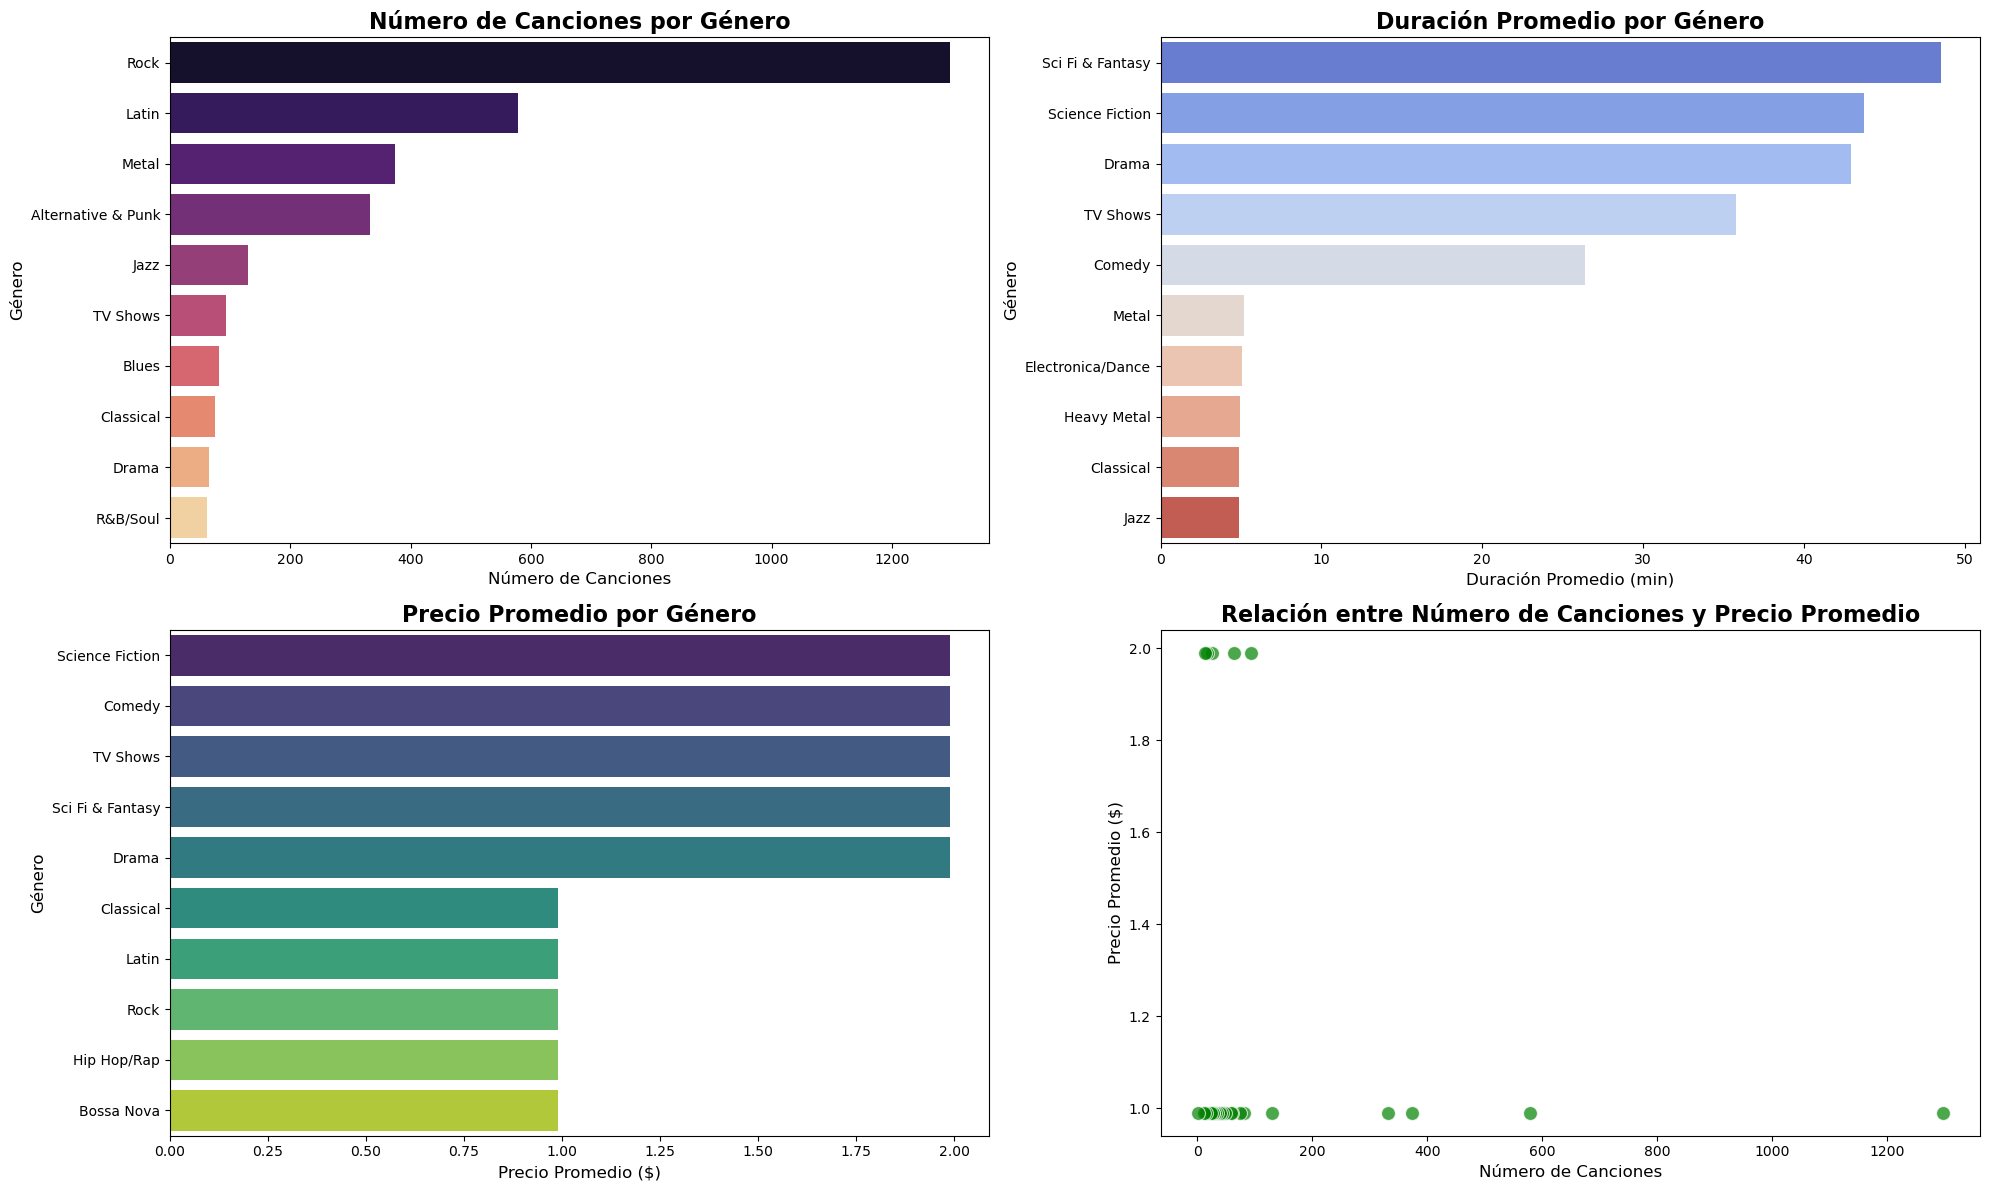


 Reporte de g√©neros por duraci√≥n promedio:

üìä Estad√≠sticas de G√©neros Musicales:
Total de g√©neros: 25
Total de canciones: 3503
Duraci√≥n promedio general: 11.12 minutos
Precio promedio general: $1.19

üèÜ G√©neros Destacados:
G√©nero con m√°s tracks: Rock
G√©nero con mayor duraci√≥n promedio: Sci Fi & Fantasy
G√©nero con precio promedio m√°s alto: TV Shows


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


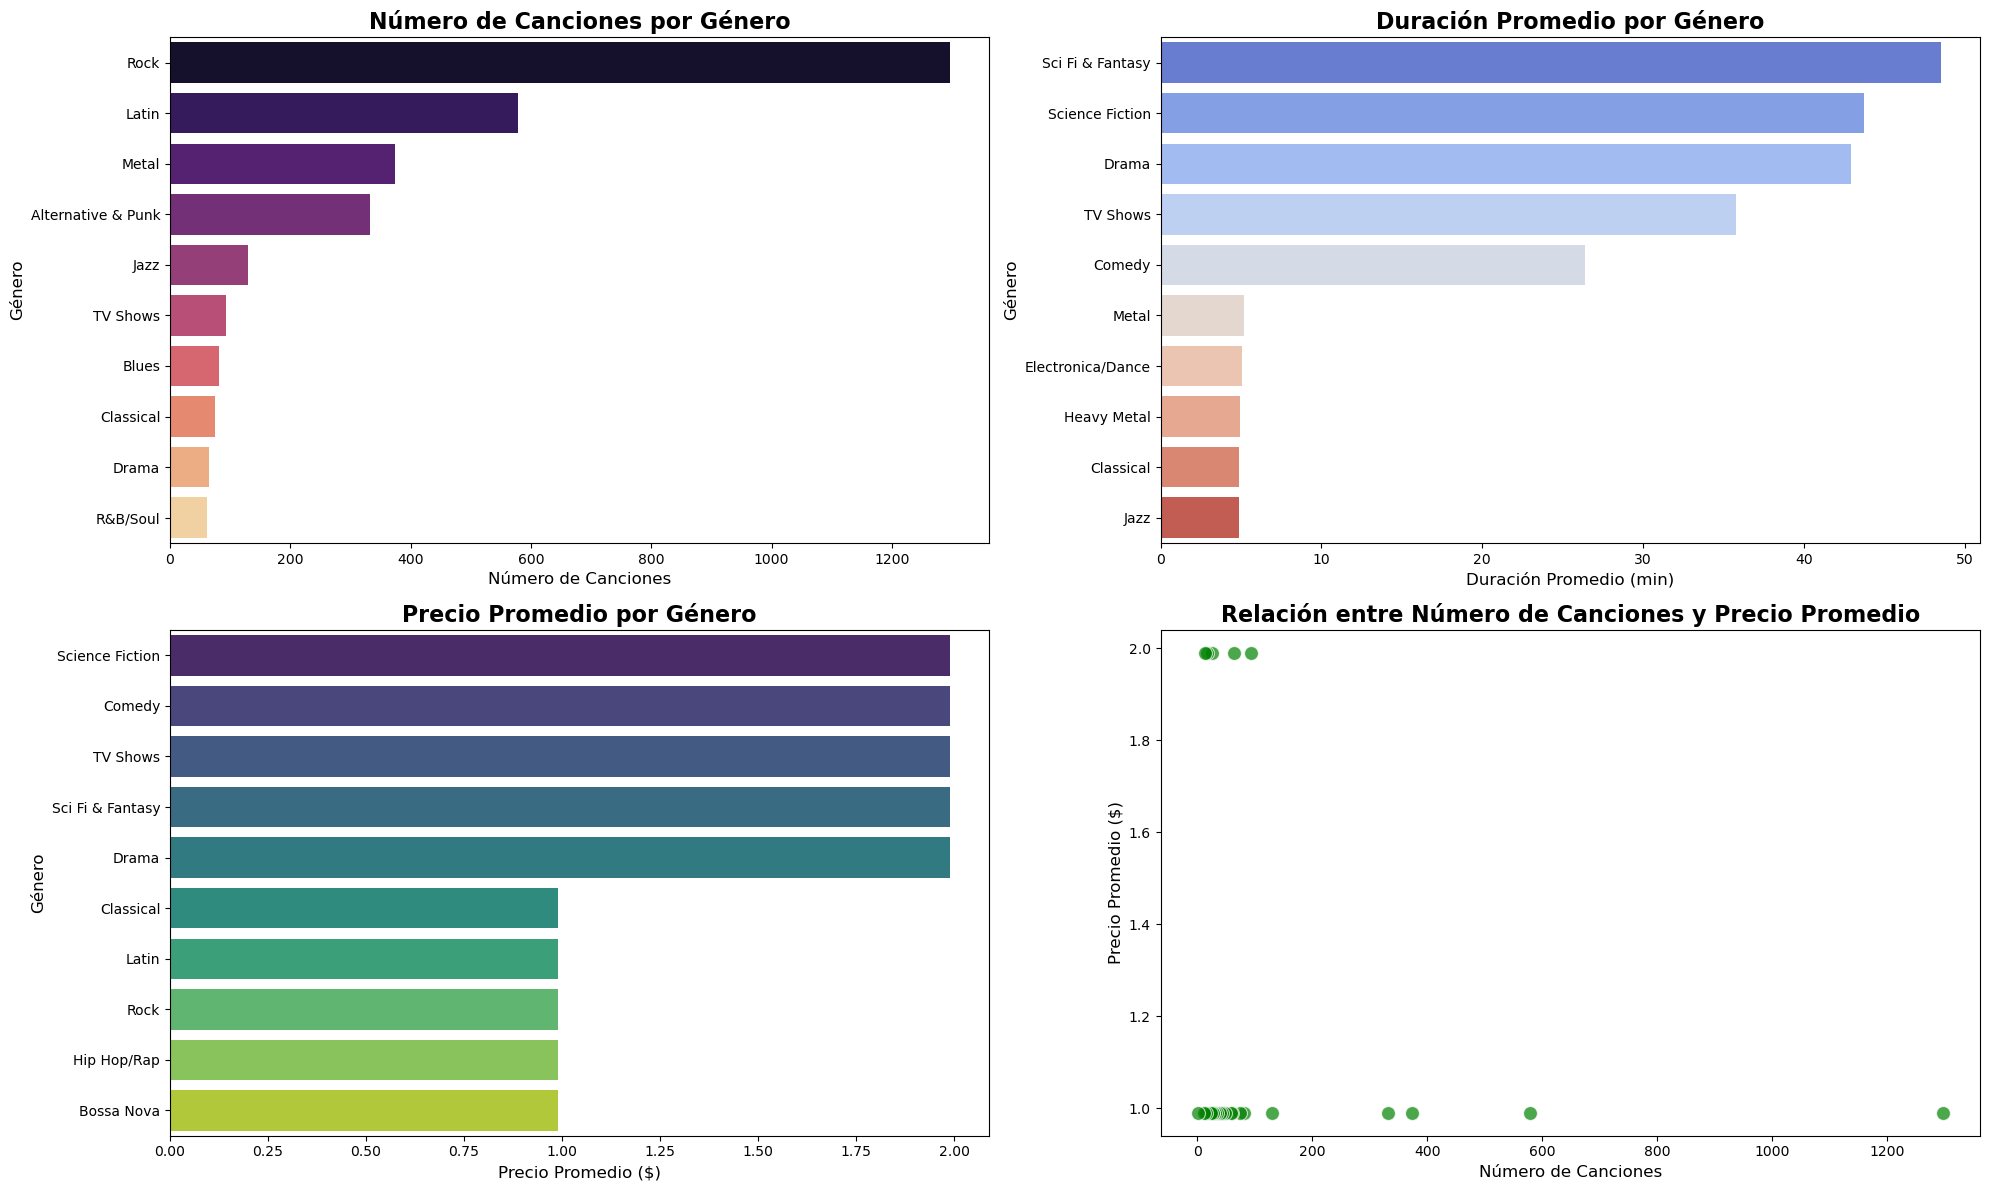


 Reporte de g√©neros por precio promedio:

üìä Estad√≠sticas de G√©neros Musicales:
Total de g√©neros: 25
Total de canciones: 3503
Duraci√≥n promedio general: 11.12 minutos
Precio promedio general: $1.19

üèÜ G√©neros Destacados:
G√©nero con m√°s tracks: Rock
G√©nero con mayor duraci√≥n promedio: Sci Fi & Fantasy
G√©nero con precio promedio m√°s alto: TV Shows


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


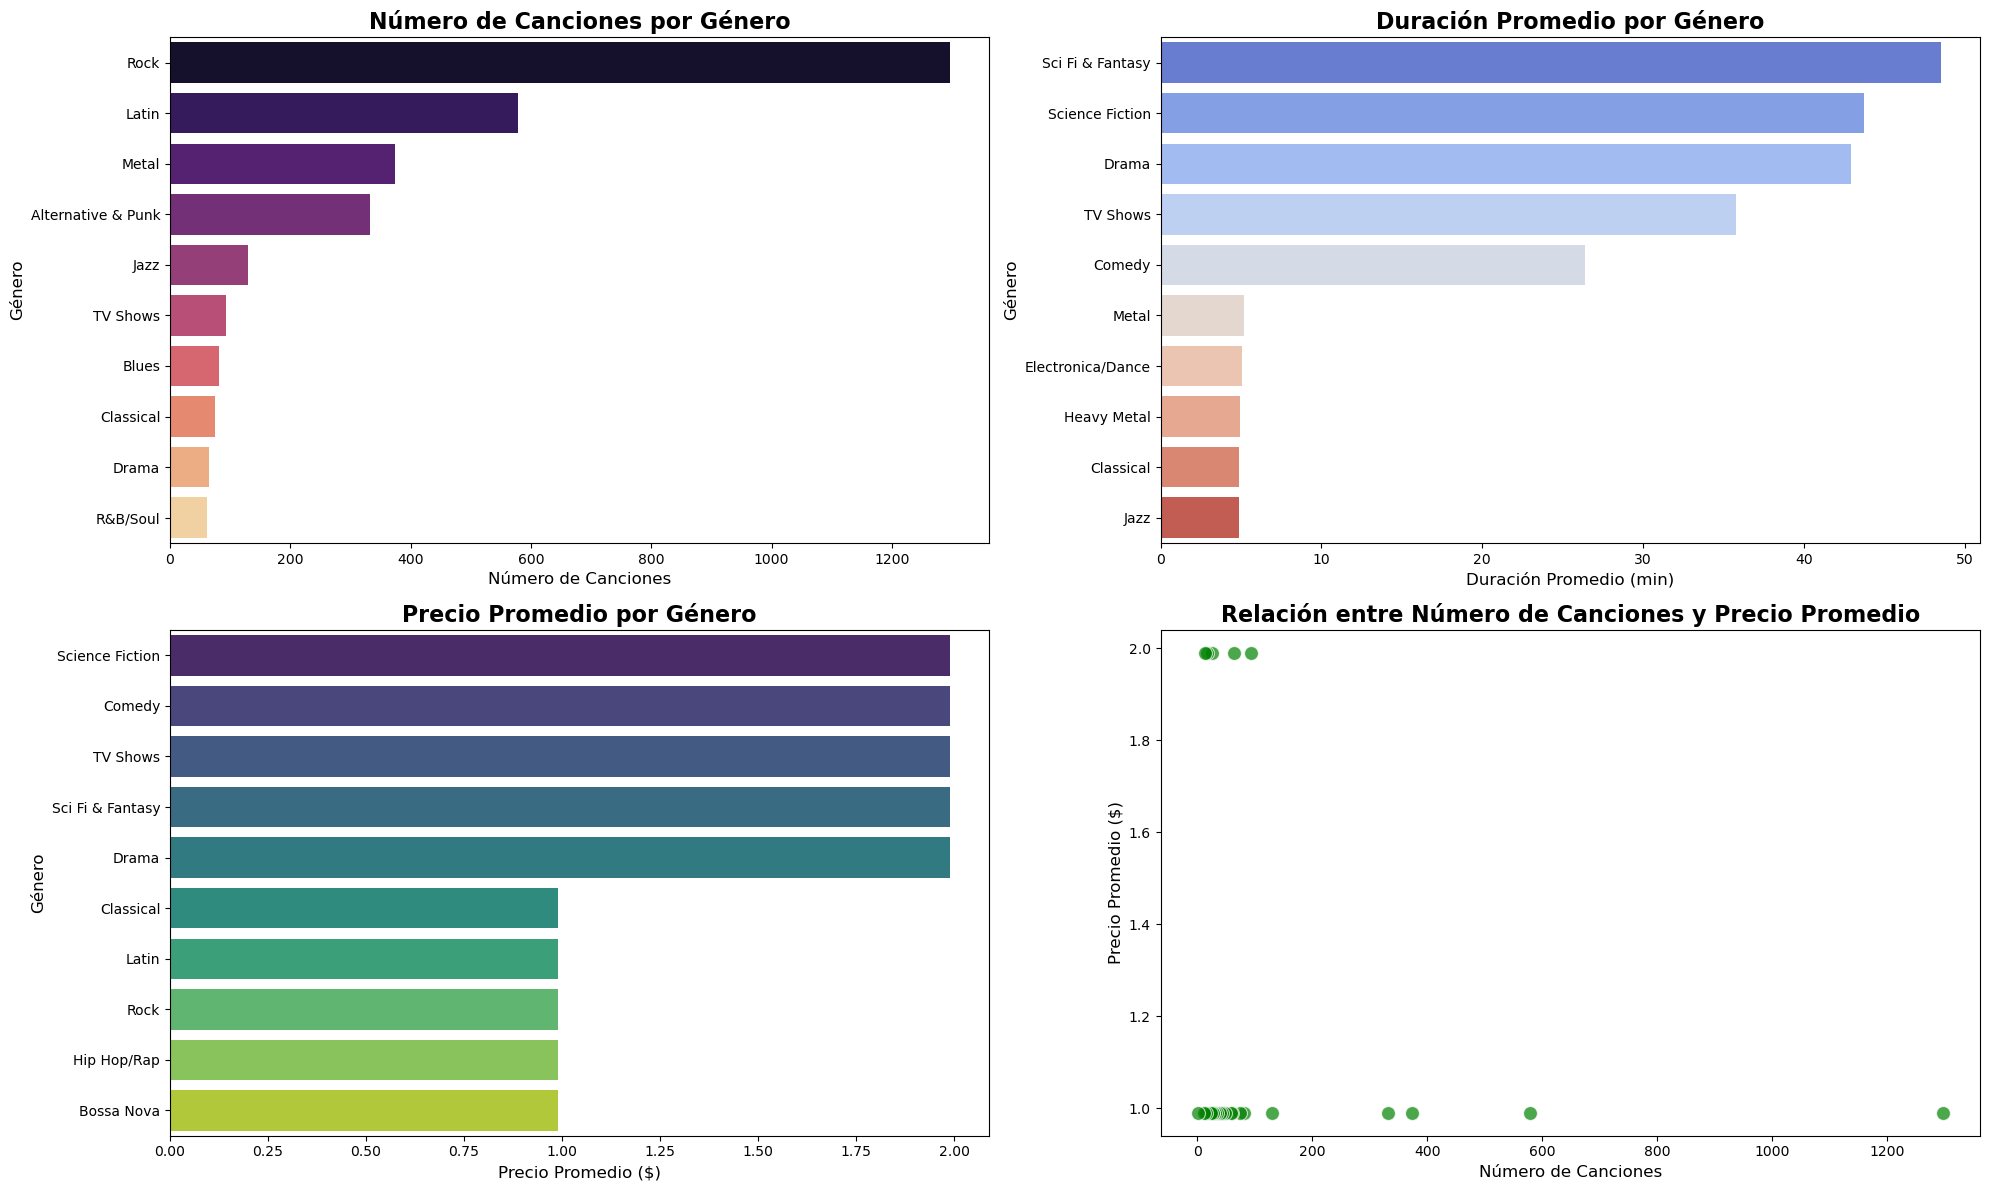


 Reporte de g√©neros con al menos 100 tracks:

üìä Estad√≠sticas de G√©neros Musicales:
Total de g√©neros: 5
Total de canciones: 2712
Duraci√≥n promedio general: 4.51 minutos
Precio promedio general: $0.99

üèÜ G√©neros Destacados:
G√©nero con m√°s tracks: Rock
G√©nero con mayor duraci√≥n promedio: Metal
G√©nero con precio promedio m√°s alto: Latin


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


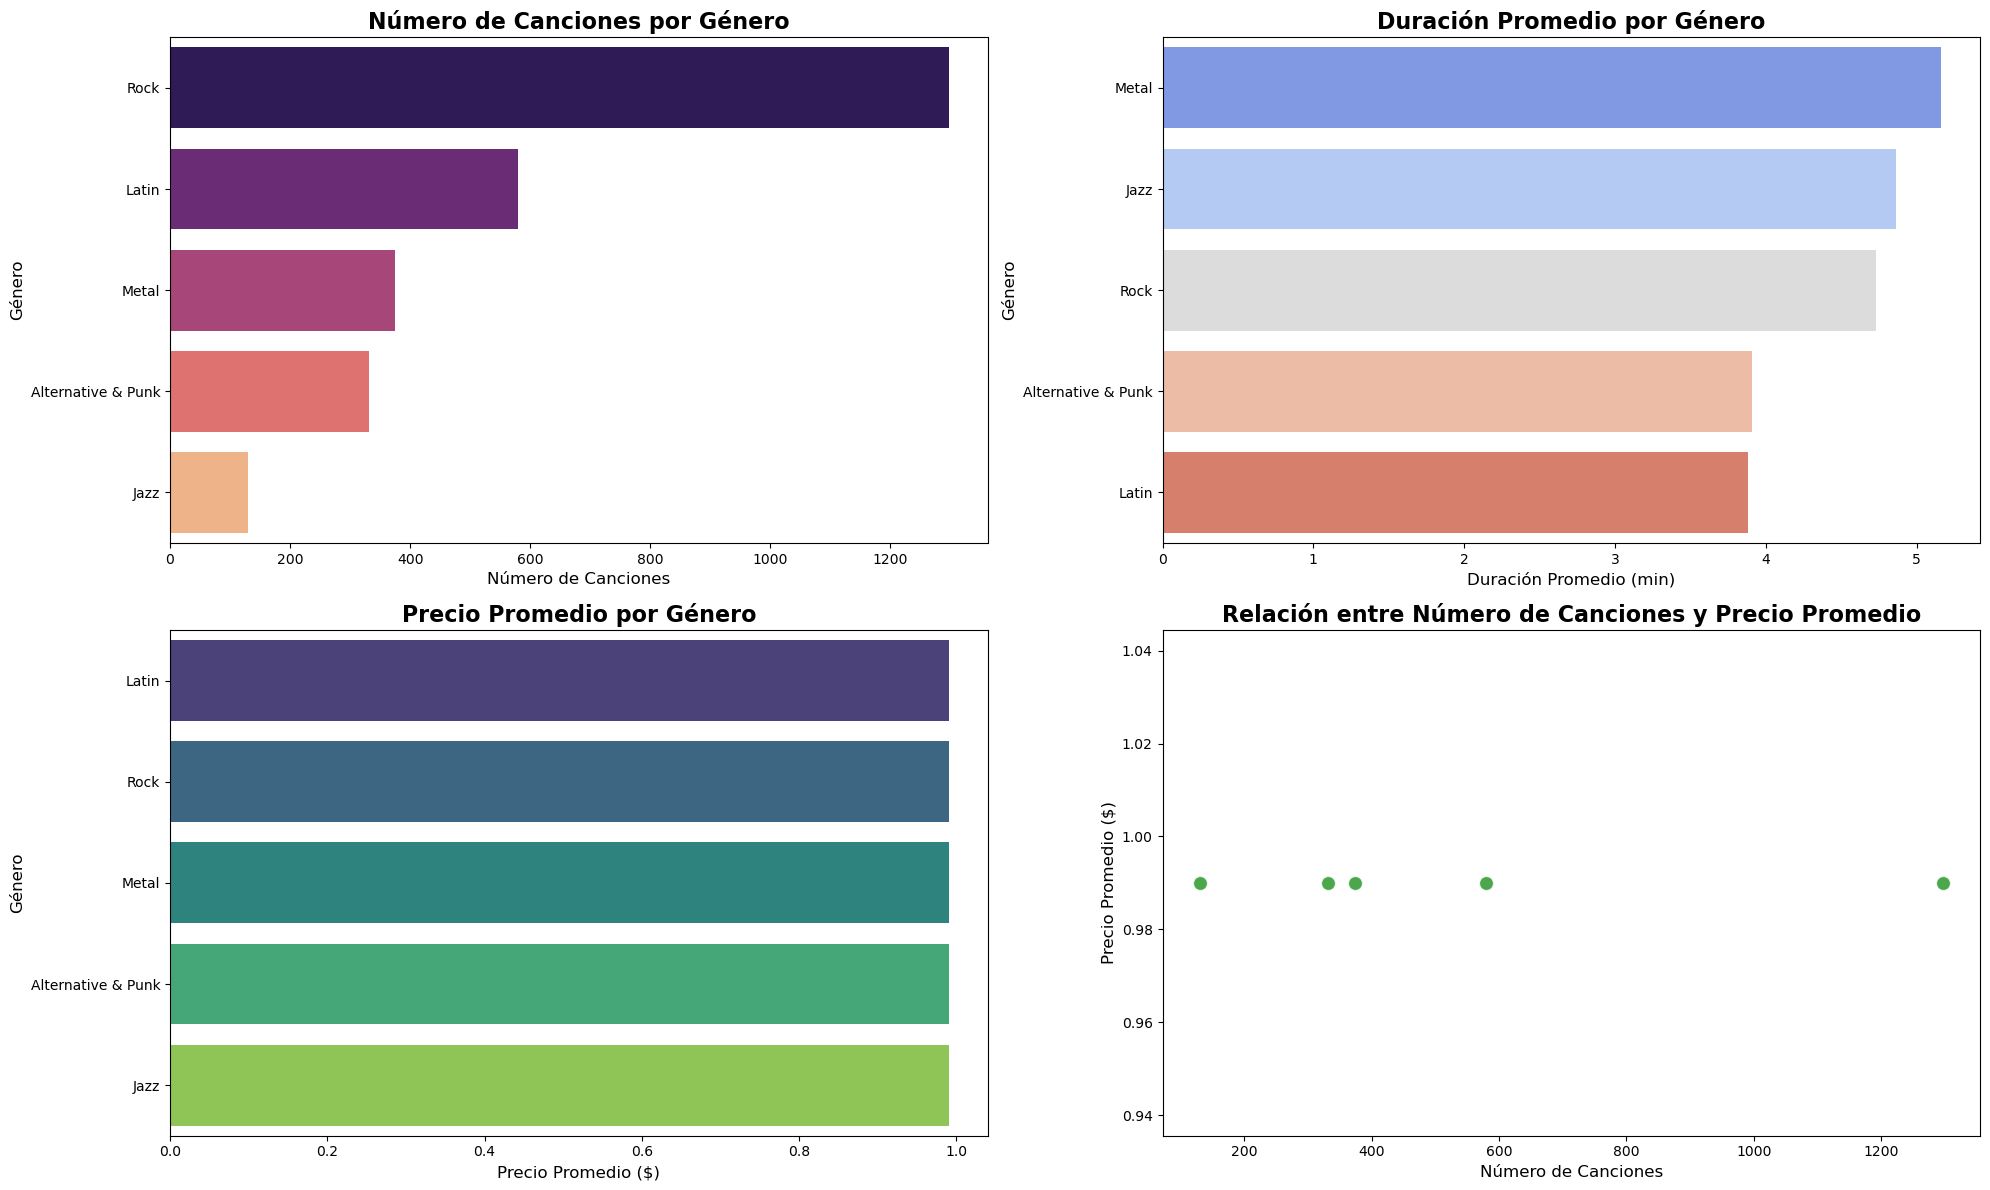

In [18]:
if __name__ == "__main__":
    # 1. An√°lisis de g√©neros por n√∫mero de tracks
    print("\n Reporte de g√©neros por n√∫mero de tracks:")
    df_generos_tracks = analizar_generos(engine)

    # 2. An√°lisis de g√©neros por duraci√≥n promedio
    print("\n Reporte de g√©neros por duraci√≥n promedio:")
    df_generos_duracion = analizar_generos(engine)

    # 3. An√°lisis de g√©neros por precio promedio
    print("\n Reporte de g√©neros por precio promedio:")
    df_generos_precio = analizar_generos(engine)

    # 4. An√°lisis de g√©neros con al menos 100 tracks
    print("\n Reporte de g√©neros con al menos 100 tracks:")
    df_generos_min100 = analizar_generos(engine, min_tracks=100)